## Overview

The essence of our group’s project was to thoroughly analyze whether yearly dietary competitions, discriminated by macronutrients and general food groups, have an impact in determining a country’s mortality rate through noncommunicable diseases. We hypothesized that, intuitively speaking, a correlation must lie in the sources of food one consumes and the life expectancy of that individual. Using datasets from Our World in Data, we completed three different classification approaches (PCA merged KNN, Linear Discriminatory Analysis, Decision Tree), as well as finding the linear regressions per food group per GDP sector (low, low-med, med-high, high), due to the discovery early in the project that GDP is actually a major confounding variable that may obstruct findings between food groups and mortality rates.

The evidence within our various approaches in attempting to classify and predict a country’s mortality rate through classification remained rather convincing that our hypothesis was qualifiedly true, with different food groups within countries in each GDP sector demonstrating more influence than others.


## Names
- Brandon Demesa
- Eva Lee
- Justin Phan
- Rhee Kang

## Research Question

Can we predict a country's rate of mortality from non-communicable disease using its average annual dietary composition (in kcal)? 

## Background and Prior Work

It is well known that a nutritious diet is fundamental to a healthy lifestyle. In general, a nutritious diet provides us with sufficient energy, aids in the maintenance of a moderate weight, and even contributes to restful sleep (1). Furthermore, it has been shown to be one of the most effective modes of preventing certain non-communicable diseases, such as cardiovascular disease (CVD), type 2 diabetes, and cancer. 

The World Health Organization (WHO) reports that non-communicable diseases are collectively responsible for the death of nearly 41 million people each year, which is equivalent to 71% of all deaths globally. 15 million of these people are between the ages of 30-69, with the majority of them occurring in both low- and middle-income countries (3). Besides the challenge that chronic disease poses to public health, they have also been shown to “exert a significant negative impact” on the economies of developing countries (2). The magnitude of this epidemic is alarming in consideration of the fact that the underlying risk factors, such as poor diet, tobacco use, consumption of alcohol, and physical inactivity, are largely preventable (3). It is imperative that countries take the necessary actions to promote methods of preventive care in order to contain the threat of this epidemic. Similarly, a report conducted by WHO and the Food and Agriculture Organization (FAO) proposed that “that nutrition should be placed at the forefront of public health policies and programmes” (4). In our project, we intend to analyze the relationship between the food groups prominent within a country's diet and their annual mortality rate from NCDs in order to inform their decision-making in regards to diet. In doing so, we hope to encourage readers to recognize the impact of their choices and the agency they have in determining the trajectory of their health.

#### References:
1. Essentials of Healthy Eating: A Guide (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3471136/)
2. Global Chronic Diseases (https://science.sciencemag.org/content/307/5708/317#:~:text=Chronic%20diseases%2C%20particularly%20cardiovascular%20disease,contributing%20to%20this%20disease%20burden.) 
3. Noncommunicable Diseases (https://www.who.int/health-topics/noncommunicable-diseases#tab=tab_1)
4. Diet, nutrition, and the prevention of chronic diseases (https://www.who.int/publications/i/item/924120916X)

## Hypothesis

We hypothesize that a country's average dietary composition can be used to predict mortality rate from non-communicable disease. Based on our research, poor diet is consistently referred to as the top risk factor for contracting NCDs, while diet has been proven to have a significant effect on overall health and life expectancy.

## Datasets

Dataset Name: Diet compositions by food groups
- Link to the Dataset: https://ourworldindata.org/diet-compositions#diet-compositions-by-food-groups
- Number of observations: Average per capita dietary energy supply by 11 different commodity groups, measured in kilocalories per person per day. 
- This dataset displays the average amount of certain food groups consumed by different countries across the world, from 1961-2013.

Dataset Name: Mortality from non-communicable diseases
- Link to the dataset: https://ourworldindata.org/grapher/mortality-from-ncds-sdgs?tab=table&time=earliest..2010
- Number of observations: Mortality rate from different countries across different 4 years with five year gaps in between
- This dataset displays the mortality rates in different countries from non-communicable diseases, such as diabetes, cardiovascular disease, chronic respiratory disease, or cancer.

We plan to combine these datasets in order to analyze if a certain country’s diet composition is correlated with low mortality rates, as well as if another country’s composition is correlated with high mortality rates. By comparing the differences in diet composition of these countries we can see if there is a certain diet composition that may be related to lower mortality from non-communicable disease.


## Setup

In [1]:
#Import all necessary libraries
import collections
import pandas as pd
import numpy as np
import seaborn as sns
# import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
# set plotting size parameter
plt.rcParams['figure.figsize'] = (17, 7)


""" 
Get data ready to compare the extremes on mortality spectrum, compare diets for differing countries?
"""

# Dietary compositions by macronutrient(carbs,fat,animal protein,plant protein) 
# and by food groups(sugar, oils and fats, meats,etc.)
df_macronutrient = pd.read_csv('~/Data Checkpoint/Data/daily-caloric-supply-derived-from-carbohydrates-protein-and-fat.csv')
df_dietary_composition = pd.read_csv('~/Data Checkpoint/Data/dietary-compositions-by-commodity-group.csv')

# Mortality rates from non-communicable diseases
df_mortality = pd.read_csv('~/Data Checkpoint/Data/mortality-from-ncds-sdgs.csv')

# GDP per capita 
df_gdp = pd.read_csv("~/Data Checkpoint/Data/share-of-calories-from-animal-protein-vs-gdp-per-capita.csv")
df_gdp = df_gdp[["Entity", "Year","Real GDP per capita in 2011US$, 2011 benchmark (Maddison Project Database (2018))"]]

#rename column 'entity' to country
df_macronutrient = df_macronutrient.rename(columns={'Entity': 'Country'})
df_dietary_composition = df_dietary_composition.rename(columns={'Entity': 'Country'})
df_mortality = df_mortality.rename(columns={'Entity': 'Country'})
df_gdp = df_gdp.rename(columns={'Entity': 'Country'})

## Data Cleaning

In [2]:
# Prune years, we only want to look at 2000-2013 and 2000,2005,2010..
df_mortality = df_mortality.drop(df_mortality[df_mortality['Year'] >= 2015].index)
df_dietary_composition = df_dietary_composition.drop(df_dietary_composition[df_dietary_composition['Year'] < 2000].index)
df_macronutrient = df_macronutrient.drop(df_macronutrient[df_macronutrient['Year'] < 2000].index)

# Different amount of rows for dietary composition and macronutrient tables, find out differences 
diet_countries = set(df_dietary_composition['Country'].unique())
macronutrient_countries = set(df_macronutrient['Country'].unique())

diff = list(macronutrient_countries.difference(diet_countries)) # Create list of the difference between tables

# Drop countries in df_macronutrient that we don't have in df_dietary_composition
df_macronutrient = df_macronutrient.drop(df_macronutrient[df_macronutrient['Country'].isin(diff)].index)

# Merge tables now that we have same number of rows
df_combined = df_macronutrient.merge(df_dietary_composition)
df_combined = df_combined.merge(df_gdp)
df_combined = df_combined.merge(df_mortality)
df_yee = df_combined

#Rename columns
df_combined = df_combined.rename(columns = {'Calories from fat (FAO (2017))': 'fat',
                                             'Calories from carbohydrates (FAO (2017))': 'carbohydrates',
                                             'Calories from animal protein (FAO (2017))': 'animal protein',
                                             'Cereals and Grains (FAO (2017)) (kilocalories per person per day)': 'cereals and grains',
                                             'Pulses (FAO (2017)) (kilocalories per person per day)': 'pulses',
                                             'Starchy Roots (FAO (2017)) (kilocalories per person per day)': 'starchy roots',
                                             'Sugar (FAO (2017)) (kilocalories per person per day)': 'sugar',
                                             'Oils & Fats (FAO (2017)) (kilocalories per person per day)': 'oils and fats',
                                             'Meat (FAO (2017)) (kilocalories per person per day)': 'meat',
                                             'Dairy & Eggs (FAO (2017)) (kilocalories per person per day)': 'dairy and eggs',
                                             'Fruit and Vegetables (FAO (2017)) (kilocalories per person per day)': 'fruits and vegetables',
                                             'Other (FAO (2017)) (kilocalories per person per day)': 'other',
                                             'Alcoholic Beverages (FAO (2017)) (kilocalories per person per day)': 'alcoholic beverages',
                                             'Calories from plant protein (FAO (2017))': 'plant protein',
                                           'Real GDP per capita in 2011US$, 2011 benchmark (Maddison Project Database (2018))' : 'GDP',
                                           'Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70 (%)' : 'mortality'})
df_combined

,Country,Code,Year,fat,carbohydrates,animal protein,plant protein,cereals and grains,pulses,starchy roots,sugar,oils and fats,meat,dairy and eggs,fruits and vegetables,other,alcoholic beverages,GDP,mortality
0,Afghanistan,AFG,2000,289.26,1290.46,59.20,151.08,1334,10,22,31,112,93,125,54,9,0.0,735.0,34.4
1,Afghanistan,AFG,2005,330.75,1403.21,52.08,161.96,1426,14,24,65,166,77,110,56,10,0.0,1187.0,34.1
2,Afghanistan,AFG,2010,304.92,1566.52,48.44,184.12,1592,22,14,87,149,72,100,56,12,0.0,1685.0,31.7
3,Albania,ALB,2000,680.04,1692.40,155.56,206.00,1331,46,55,188,242,154,470,193,26,29.0,5097.0,19.4
4,Albania,ALB,2005,797.40,1683.64,195.44,197.52,1207,45,60,192,273,219,548,265,24,41.0,7080.0,18.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
480,Zambia,ZMB,2005,334.71,1334.09,38.52,165.68,1092,31,281,105,208,70,23,27,8,28.0,2361.0,21.1
481,Zambia,ZMB,2010,378.45,1315.03,39.16,171.36,1057,15,298,99,262,78,24,29,9,33.0,3125.0,19.9
482,Zimbabwe,ZWE,2000,468.00,1326.28,38.00,146.72,1108,32,45,269,315,67,53,21,9,60.0,2249.0,21.6
483,Zimbabwe,ZWE,2005,489.06,1337.62,43.08,155.24,1155,43,53,232,321,83,49,21,13,55.0,1510.0,22.5


## Data Analysis & Results

### Exploratory Data Analysis

Text(0.5, 1.0, 'Top 5 Countries - Calories derived from macronutrients per day')

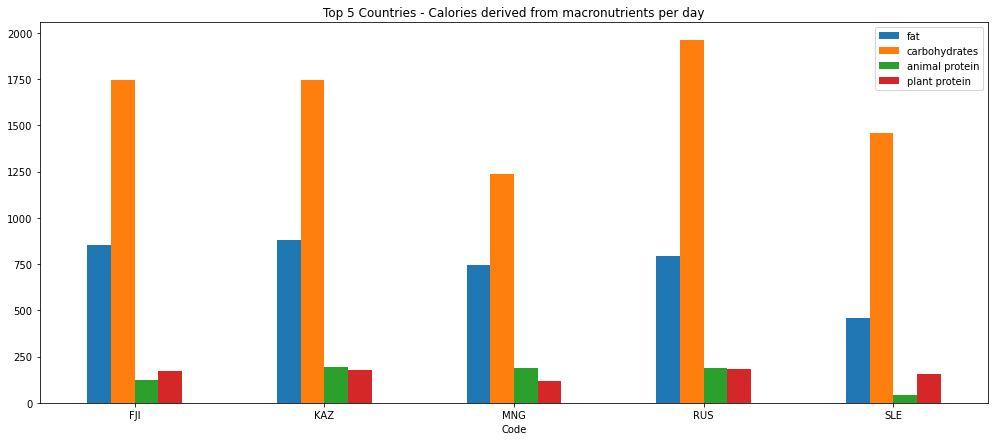

In [3]:
cols = ['Country','Code','Year','mortality']
df_mortality1 = df_combined[cols]
df_mortality_avg = pd.DataFrame(df_mortality1.groupby('Code')['mortality'].sum())
df_mortality_avg['mortality'] = (df_mortality_avg['mortality']/3)
df_mortality_avg = df_mortality_avg.rename(columns={'mortality':'Average mortality rate from NCD'})
df_mortality_avg = df_mortality_avg.sort_values(by=['Average mortality rate from NCD'],ascending=False)

# Retrieved from sorted dataframe and using head(5)
# Include Kazakhstan, Mongolia, Fiji, Russia, Sierra Leone
top_5 = ["KAZ","MNG","FJI","RUS","SLE"] 
top_5_df= df_combined[df_combined['Code'].isin(top_5)]
top_5_df = top_5_df.groupby("Code").mean()
top_5_df = top_5_df.drop(columns="Year")
top_5_df = top_5_df.reset_index()

# Make graph for calories from diff macronutrients
top_5_bar = top_5_df.plot.bar(rot=0,x="Code",y=["fat","carbohydrates","animal protein","plant protein"])
top_5_bar.set_title('Top 5 Countries - Calories derived from macronutrients per day')

In [4]:
df_mortality_avg.head()

,Average mortality rate from NCD
Code,
KAZ,37.000000
MNG,35.600000
FJI,34.966667
RUS,34.833333
SLE,34.133333


The graph above showcases the average daily distribution of calories derived from various macronutrients among the countries (Kazakhstan, Mongolia, Fiji, Russia, Sierra Leone respectively) with the highest mortality rate from non-communicable disease. It is clear that the majority of all 5 countries' caloric intake is composed of carbohydrates, which is distantly followed by fat. The remaining macronutrients, animal and plant protein, are generally consumed at very low rates which hardly surpass 250 calories. They also appear to be consumed in relatively inconsistent proportions. Fiji and Sierra Leone, for example, appear to consume more plant protein than animal protein, while Mongolia consumes more animal protein than plant protein. Russia and Kazakhstan, on the other hand, consume both in nearly equal amounts.

Text(0.5, 1.0, 'Bottom 5 Countries - Calories derived from macronutrients per day')

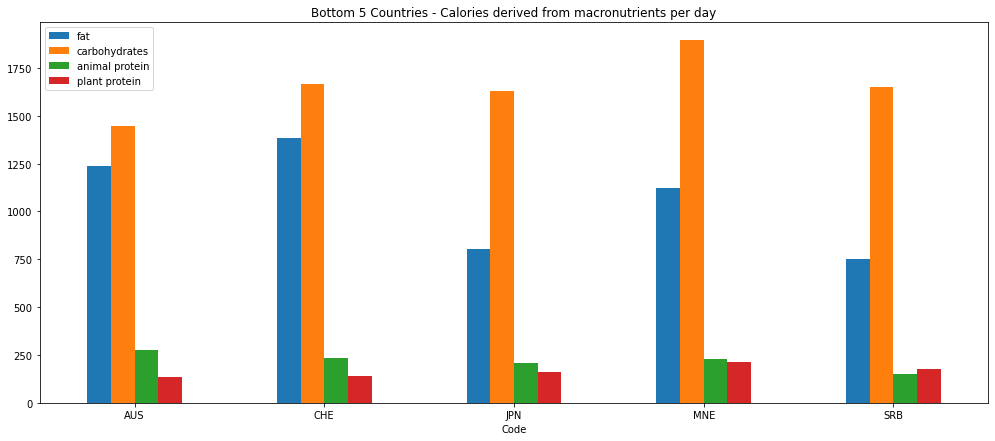

In [5]:
# Retrieved from sorted dataframe and using tail(5)
# Include Australia, Switzerland, Japan, Serbia, Montenegro
bot_5 = ["AUS","CHE","JPN","SRB","MNE"]
bot_5_df= df_combined[df_combined['Code'].isin(bot_5)]
bot_5_df = bot_5_df.groupby("Code").mean()
bot_5_df = bot_5_df.drop(columns="Year")

# Make graph for calories from diff macronutrients
bot_5_bar = bot_5_df.plot.bar(rot=0,y=["fat","carbohydrates","animal protein","plant protein"])
bot_5_bar.set_title('Bottom 5 Countries - Calories derived from macronutrients per day')

In [6]:
df_mortality_avg.tail()

,Average mortality rate from NCD
Code,
AUS,11.500000
CHE,11.066667
JPN,10.433333
SRB,7.500000
MNE,7.366667


The graph above showcases the average daily distribution of calories derived from various macronutrients among the countries (Australia, Switzerland, Japan, Serbia, and Montenegro respectively) with the lowest mortality rate from non-communicable disease. Similar to the countries with the highest mortality rate, these countries also seem to derive the majority of their calories from carbohydrates. In contrast, however, fats seem to follow closely behind rather than distantly. Australia and Switzerland, in particular, derive a very significant amount of calories from fat as both appear to surpass ~1250 calories. While animal protein and plant protein remain the macronutrients contributing the least amount of calories, the proportions are much more consistent among these countries. All of the countries (besides Serbia) appear to consume more animal protein than plant protein.

Text(0.5, 1.0, 'Top 5 Countries - Calories derived from Commodity Groups')

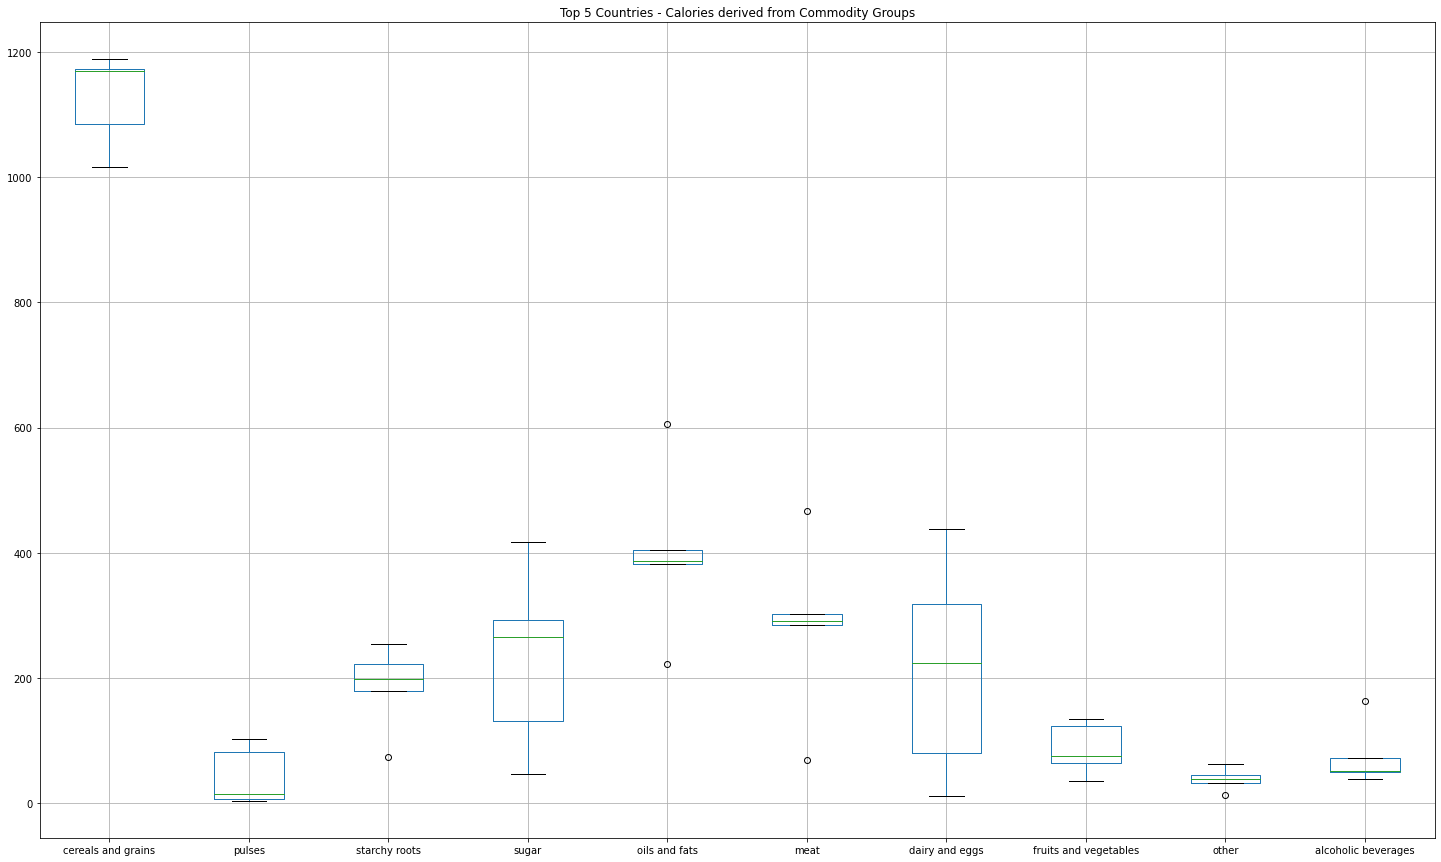

In [7]:
top_5_box = top_5_df.boxplot(figsize=(25,15),column=['cereals and grains',
       'pulses',
       'starchy roots',
       'sugar',
       'oils and fats',
       'meat',
       'dairy and eggs',
       'fruits and vegetables',
       'other',
       'alcoholic beverages'])
top_5_box.set_title('Top 5 Countries - Calories derived from Commodity Groups')

The boxplot above shows the distribution of different food groups (food commodity distribution) for the five countries with the highest mortality rates from non-communicable diseases (Kazakhstan, Mongolia, Fiji, Russia, and Sierra Leone respectively). The graph showcases that cereals and grains have the highest consumption rates (consistent with the fact that findings from the macronutrient plot), while pulses (AKA legumes) possess the lowest rates. The boxplots show the medians, interquartile ranges, maximums, and minimums of the data from each food commodity. When comparing these boxplots to those of the countries with the lowest mortality rates, it can be seen that the consumption of meats and oils and fast is significantly less. The crate of consumption of vegetables in these countries also has a significantly lower minimum and more variance than countries with the lowest mortality rate.

Text(0.5, 1.0, 'Bottom 5 Countries - Calories derived from Commodity Groups')

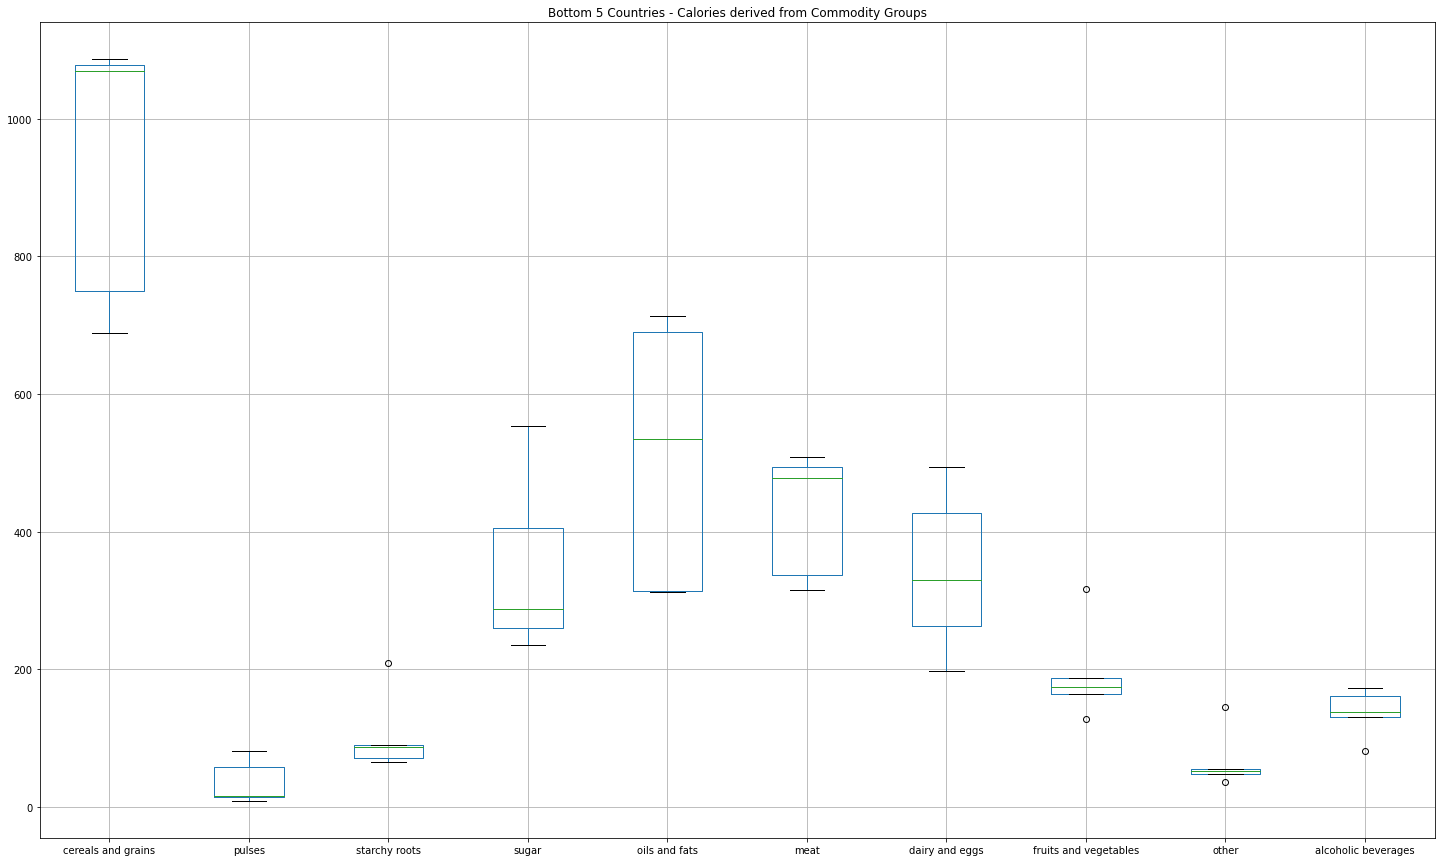

In [8]:
bot_5_box = bot_5_df.boxplot(figsize=(25,15),column=['cereals and grains',
       'pulses',
       'starchy roots',
       'sugar',
       'oils and fats',
       'meat',
       'dairy and eggs',
       'fruits and vegetables',
       'other',
       'alcoholic beverages'])
bot_5_box.set_title('Bottom 5 Countries - Calories derived from Commodity Groups')

The boxplot here shows the distribution of different food groups (food commodity distribution) for the five countries with the lowest mortality rates from non-communicable diseases (Australia, Switzerland, Japan, Serbia, and Montenegro respectively). Although the overall ratios between the food commodity groups appear to be relatively similar, compared to the boxplots of the countries with the top five highest mortality rates, it can be seen that the consumption of oils and fats, meats, fruits and vegetables are much higher. There is also more variation and larger interquartile ranges in these boxplots as opposed to the high mortality rate countries.

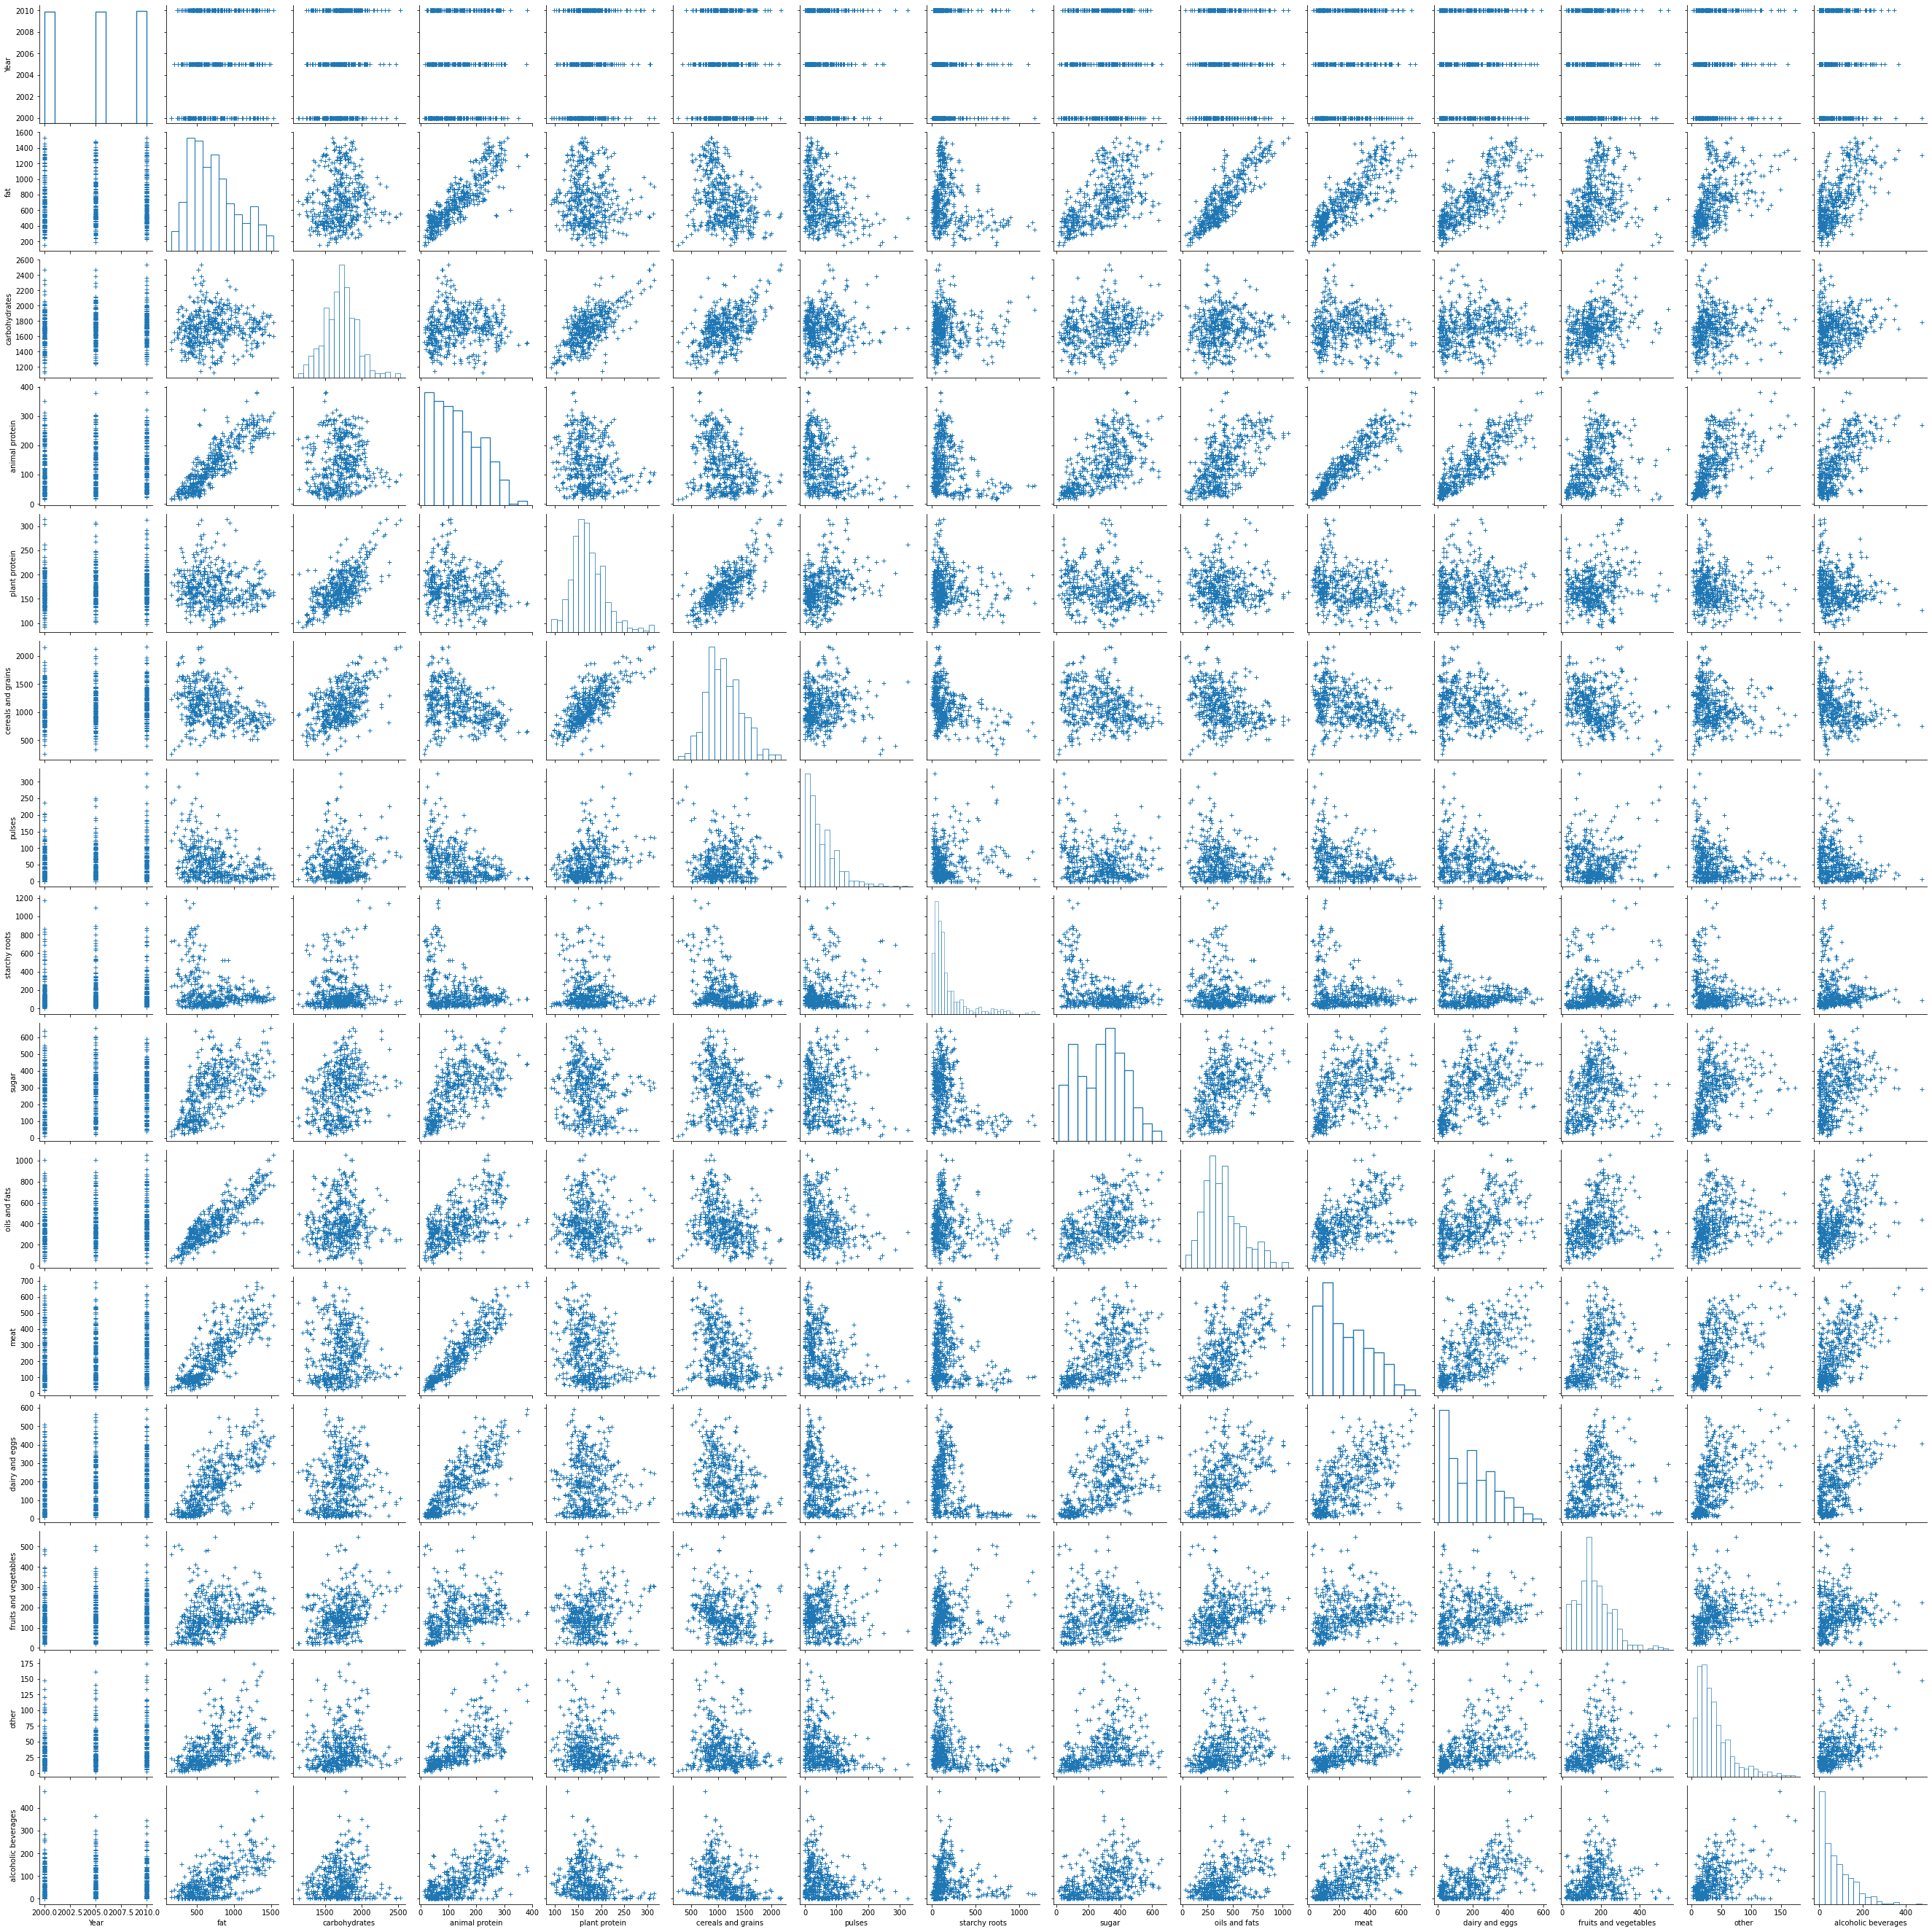

In [9]:
temp = df_combined.drop(["mortality", "GDP"], axis = 1)
sns.pairplot(temp, plot_kws=dict(marker="+", linewidth=1),
    diag_kws=dict(fill=False))

The pairplot above provides a general overview of the countries' relationship to each of the components of food.

## Decision Tree

We used a decision tree to indicate which diet features are optimal for determining a country's mortality rate from NCDs. In order to mitigate the confounding factor of GDP, we split the countries into four categories based on the quartile of their GDP.

In [10]:
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, precision_recall_fscore_support
from sklearn.model_selection import train_test_split

df_avg = pd.DataFrame(df_combined.groupby('Country')['mortality'].mean())
df_combined.merge(df_avg)

,Country,Code,Year,fat,carbohydrates,animal protein,plant protein,cereals and grains,pulses,starchy roots,sugar,oils and fats,meat,dairy and eggs,fruits and vegetables,other,alcoholic beverages,GDP,mortality
0,Australia,AUS,2000,1170.09,1415.71,271.48,133.72,659,10,88,407,625,506,323,182,48,143.0,39200.0,13.1
1,Germany,DEU,2010,1296.90,1799.54,247.36,160.20,876,7,119,485,795,404,380,165,41,232.0,41576.0,13.1
2,Luxembourg,LUX,2005,1367.46,1694.34,302.24,137.96,772,18,72,296,413,657,533,215,162,364.0,52037.0,13.1
3,Bahamas,BHS,2005,831.87,1490.21,214.92,111.00,628,17,51,421,324,536,173,260,106,132.0,NaN,18.5
4,Slovenia,SVN,2000,970.47,1676.17,240.08,169.28,968,8,149,192,492,369,343,248,85,202.0,20514.0,18.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,Russia,RUS,2000,688.05,1847.87,165.64,175.44,1151,10,202,387,328,239,290,109,38,123.0,13563.0,37.0
98,Saudi Arabia,SAU,2005,747.09,1909.03,135.56,199.32,1429,41,36,316,407,229,166,298,69,0.0,44800.0,18.4
99,Venezuela,VEN,2010,777.15,1717.49,158.40,151.96,1093,61,76,395,446,268,210,132,25,99.0,17204.0,18.4
100,Vietnam,VNM,2005,482.94,1724.86,87.84,172.36,1574,25,36,118,163,344,26,130,21,31.0,3558.0,18.4


In [11]:
final_total = pd.DataFrame(df_combined.groupby('Country')['mortality'].mean())
final_total['animal protein'] = (df_combined.groupby('Country')['animal protein'].mean())
final_total['fat'] = df_combined.groupby('Country')['fat'].mean()
final_total['carbohydrates'] = df_combined.groupby('Country')['carbohydrates'].mean()
final_total['plant protein'] = df_combined.groupby('Country')['plant protein'].mean()
final_total['cereals and grains'] = df_combined.groupby('Country')['cereals and grains'].mean()
final_total['pulses'] = df_combined.groupby('Country')['pulses'].mean()
final_total['starchy roots'] = df_combined.groupby('Country')['starchy roots'].mean()
final_total['sugar'] = df_combined.groupby('Country')['sugar'].mean()
final_total['oils and fats'] = df_combined.groupby('Country')['oils and fats'].mean()
final_total['meat'] = df_combined.groupby('Country')['meat'].mean()
final_total['dairy and eggs'] = df_combined.groupby('Country')['dairy and eggs'].mean()
final_total['fruits and vegetables'] = df_combined.groupby('Country')['fruits and vegetables'].mean()
final_total['GDP'] = df_combined.groupby('Country')['GDP'].mean()
final_total['alcoholic beverages'] = df_combined.groupby('Country')['alcoholic beverages'].mean()
final_total = final_total.dropna()
final_total

,mortality,animal protein,fat,carbohydrates,plant protein,cereals and grains,pulses,starchy roots,sugar,oils and fats,meat,dairy and eggs,fruits and vegetables,GDP,alcoholic beverages
Country,,,,,,,,,,,,,,,
Afghanistan,33.400000,53.240000,308.31,1420.063333,165.720000,1450.666667,15.333333,20.000000,61.000000,142.333333,80.666667,111.666667,55.333333,1202.333333,0.000000
Albania,18.933333,192.080000,798.69,1702.203333,201.693333,1225.333333,45.666667,63.666667,188.666667,279.666667,233.000000,519.666667,267.666667,7149.666667,44.666667
Algeria,18.033333,84.093333,588.60,2054.173333,243.800000,1643.333333,59.000000,103.000000,274.333333,356.000000,94.000000,204.333333,213.666667,12079.666667,4.666667
Angola,21.133333,54.933333,400.98,1486.846667,128.573333,654.333333,69.666667,654.333333,115.000000,241.333333,139.333333,27.000000,102.000000,5578.333333,58.333333
Argentina,19.100000,256.853333,1008.57,1765.176667,143.400000,1035.333333,6.666667,94.666667,473.666667,420.333333,561.333333,308.333333,139.666667,16654.333333,104.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Venezuela,19.800000,133.120000,679.65,1631.256667,138.973333,983.000000,50.000000,78.000000,389.000000,411.000000,229.333333,152.333333,155.333333,15858.666667,113.000000
Vietnam,18.333333,89.573333,485.10,1715.073333,171.920000,1567.000000,26.000000,35.000000,119.666667,168.666667,341.000000,28.000000,125.000000,3592.000000,29.666667
Yemen,32.533333,48.346667,397.50,1499.820000,181.333333,1328.666667,57.333333,22.333333,253.333333,227.666667,89.666667,52.666667,81.333333,4496.000000,0.666667


In [12]:
clean = final_total.dropna()
macro_cols = ['animal protein', 'fat', 'carbohydrates', 'plant protein']
macro_cols_gdp = ['animal protein', 'fat', 'carbohydrates', 'plant protein', 'GDP']
macronutrient = clean[macro_cols]
macronutrient_gdp = clean[macro_cols_gdp]

In [13]:
testX = macronutrient
testY = clean['mortality']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(testX, testY, test_size=0.2, random_state=1)
r = DecisionTreeRegressor()
r.fit(X_train, y_train)
y_pred = r.predict(X_test)

We did two decision trees with the macronutrient groups, one with GDP and one without GDP. Here, we see animal protein has a very high feature importance compared to the other macronutrients, but later GDP takes its place as the most important feature when we consider GDP.

[0.57825701 0.11312612 0.20911466 0.09950221]


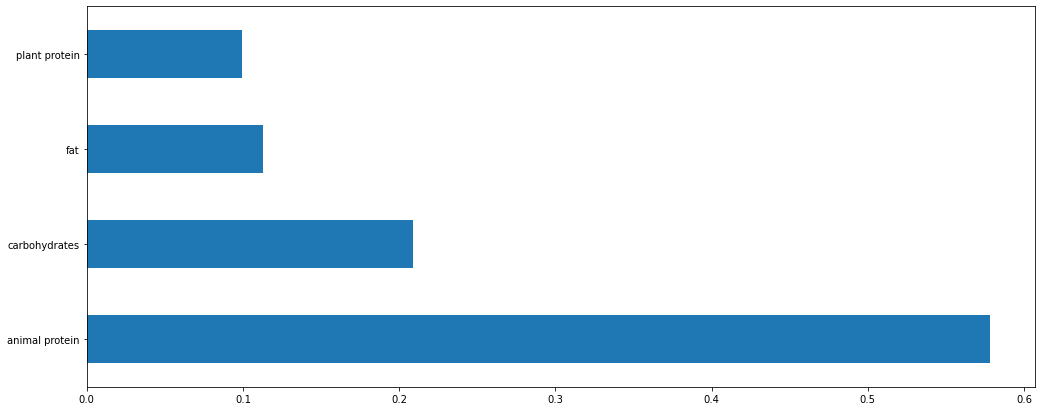

In [15]:
print(r.feature_importances_)
feat_importances = pd.Series(r.feature_importances_, index=testX.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [16]:
testX = macronutrient_gdp
testY = clean['mortality']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(testX, testY, test_size=0.2, random_state=1)
r = DecisionTreeRegressor()
r.fit(X_train, y_train)
y_pred = r.predict(X_test)

[0.19761563 0.06835475 0.09415024 0.11822052 0.52165887]


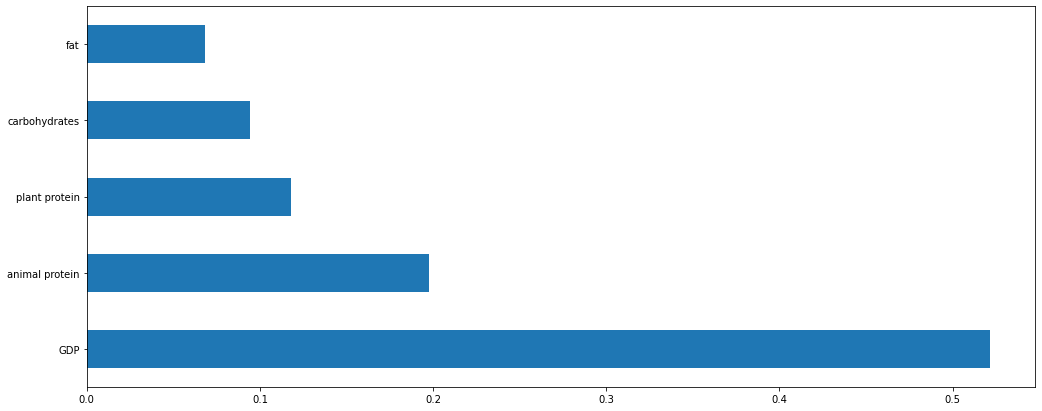

In [18]:
print(r.feature_importances_)
feat_importances = pd.Series(r.feature_importances_, index=testX.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

Here, we are going to do the same thing we did for the macronutrient groups but instead with the different types of food groups. We also did two decision trees for these datasets, one with GDP and one without. 

In [19]:
diet_comp_cols_with_gdp = ['cereals and grains', 'pulses', 'starchy roots', 'sugar', 'oils and fats', 'meat', 'dairy and eggs', 'fruits and vegetables', 'alcoholic beverages', 'GDP']
diet_comp_cols = ['cereals and grains', 'pulses', 'starchy roots', 'sugar', 'oils and fats', 'meat', 'dairy and eggs', 'fruits and vegetables', 'alcoholic beverages']
diet_comp_gdp = clean[diet_comp_cols_with_gdp]
diet_comp = clean[diet_comp_cols]

In [20]:
dietX = diet_comp
dietY = clean['mortality']

X_train, X_test, y_train, y_test = train_test_split(dietX, dietY, test_size=0.2, random_state=1)
rDiet = DecisionTreeRegressor()
rDiet.fit(X_train, y_train)
y_pred = rDiet.predict(X_test)

Here, we can see that meat has the highest feature importance when GDP is not included as a feature, but later on we see that its feature importance drops drastically when we do include GDP.

[0.02574731 0.13921754 0.18390823 0.01694816 0.05360109 0.32154989
 0.02965154 0.16905188 0.06032435]


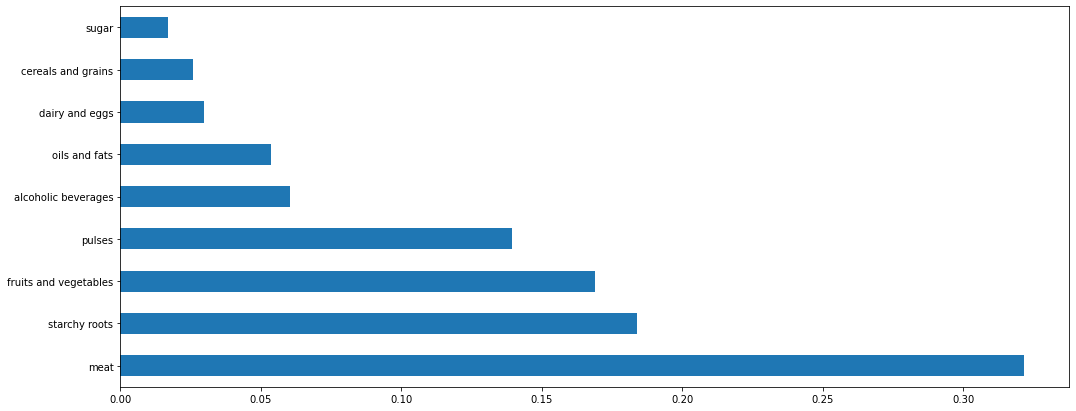

In [21]:
print(rDiet.feature_importances_)
feat_importances = pd.Series(rDiet.feature_importances_, index=dietX.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [22]:
dietX = diet_comp_gdp
dietY = clean['mortality']

X_train, X_test, y_train, y_test = train_test_split(dietX, dietY, test_size=0.2, random_state=1)
rDiet = DecisionTreeRegressor()
rDiet.fit(X_train, y_train)
y_pred = rDiet.predict(X_test)

[0.00653756 0.14655484 0.07099721 0.04270152 0.01179736 0.046037
 0.05438031 0.19180096 0.0371249  0.39206833]


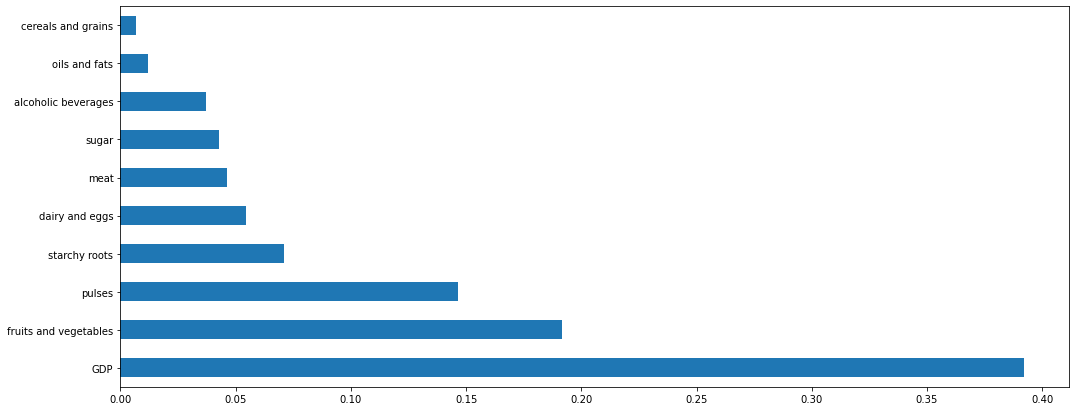

In [23]:
print(rDiet.feature_importances_)
feat_importances = pd.Series(rDiet.feature_importances_, index=dietX.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

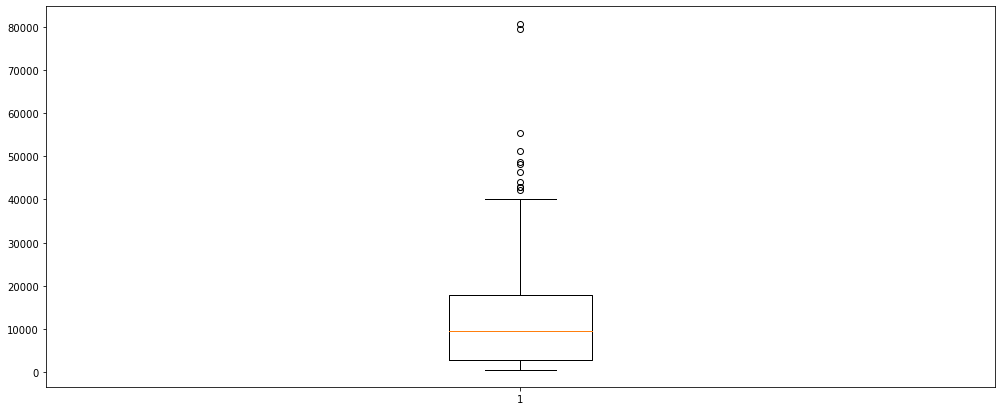

count      148.000000
mean     14197.898649
std      15322.071839
min        629.333333
25%       2715.750000
50%       9581.000000
75%      17759.916667
max      80703.333333
Name: GDP, dtype: float64

In [24]:
plt.boxplot(final_total["GDP"])
plt.show()
final_total["GDP"].describe()

In [25]:
top_25_GDP = final_total[final_total["GDP"] > 18142.666667]
top_25_GDP = top_25_GDP.drop("GDP", axis = 1)
top_50_GDP = final_total[final_total["GDP"] > 9591.000000]
top_50_GDP = top_50_GDP.drop("GDP", axis = 1)
top_75_GDP = final_total[final_total["GDP"] > 2719.333333]
top_75_GDP = top_75_GDP.drop("GDP", axis = 1)
last_25_GDP = final_total[final_total["GDP"] > 0]
last_25_GDP = last_25_GDP.drop("GDP", axis = 1)
top_25, top_50, top_75, low_25 = top_25_GDP, top_50_GDP, top_75_GDP, last_25_GDP

In [26]:
print("HIGHEST 75% QUARTILE GDP")
clean75 = top_75_GDP.dropna()
macro_cols = ['animal protein', 'fat', 'carbohydrates', 'plant protein']
macronutrient = clean75[macro_cols]
macronutrient
testX = macronutrient
testY = clean75['mortality']
mean = testY.mean()
mean
X_train, X_test, y_train, y_test = train_test_split(testX, testY, test_size=0.4, random_state=1)
r = DecisionTreeRegressor()
r.fit(X_train, y_train)
y_pred = r.predict(X_test)
df = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
df

HIGHEST 75% QUARTILE GDP


,Actual,Predicted
Country,,
Slovakia,22.866667,27.033333
Indonesia,26.700000,19.000000
Laos,28.666667,25.300000
Philippines,27.600000,21.966667
Morocco,18.933333,18.033333
Turkmenistan,33.533333,18.933333
Thailand,17.566667,21.966667
Lebanon,19.633333,22.166667
Gabon,15.766667,21.800000


In [27]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 6.874074074074076
Mean Squared Error: 81.7800987654321
Root Mean Squared Error: 9.043234972366475


[0.47507936 0.0756014  0.088447   0.36087223]


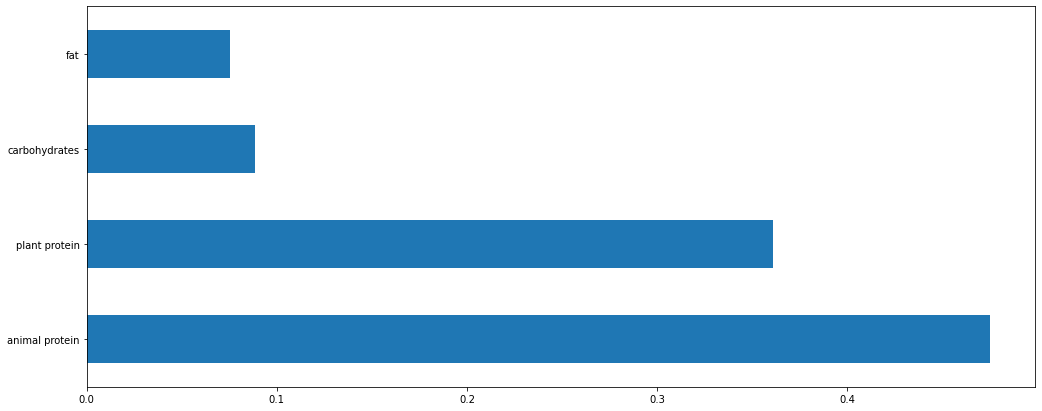

In [28]:
print(r.feature_importances_)
feat_importances = pd.Series(r.feature_importances_, index=testX.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [29]:
diet_comp_cols_with_gdp = ['cereals and grains', 'pulses', 'starchy roots', 'sugar', 'oils and fats', 'meat', 'dairy and eggs', 'fruits and vegetables', 'alcoholic beverages']
diet_comp_cols = ['cereals and grains', 'pulses', 'starchy roots', 'sugar', 'oils and fats', 'meat', 'dairy and eggs', 'fruits and vegetables', 'alcoholic beverages']
diet_comp_gdp = clean75[diet_comp_cols_with_gdp]
diet_comp = clean75[diet_comp_cols]

In [30]:
dietX = diet_comp
dietY = clean75['mortality']

X_train, X_test, y_train, y_test = train_test_split(dietX, dietY, test_size=0.2, random_state=1)
rDiet = DecisionTreeRegressor()
rDiet.fit(X_train, y_train)
y_pred = rDiet.predict(X_test)


df = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
df


,Actual,Predicted
Country,,
Slovakia,22.866667,19.100000
Indonesia,26.700000,18.033333
Laos,28.666667,18.333333
Philippines,27.600000,30.500000
Morocco,18.933333,19.000000
Turkmenistan,33.533333,28.566667
Thailand,17.566667,13.533333
Lebanon,19.633333,20.066667
Gabon,15.766667,27.700000


[2.02345570e-01 1.72650321e-01 6.79094171e-02 4.60712644e-02
 2.84054511e-01 1.09226363e-01 2.27682850e-04 6.74808425e-02
 5.00340282e-02]


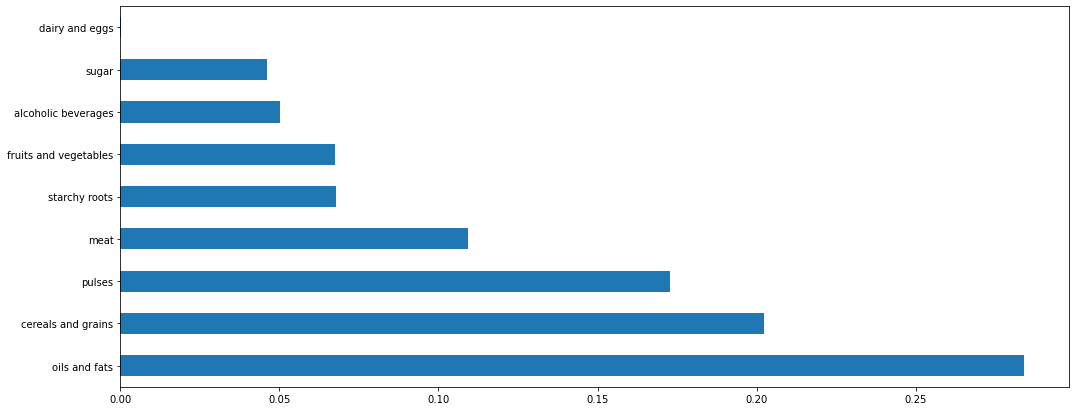

In [31]:
print(rDiet.feature_importances_)
feat_importances = pd.Series(rDiet.feature_importances_, index=dietX.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [32]:
print("HIGHEST 50% QUARTILE GDP")
clean50 = top_50_GDP.dropna()
macro_cols = ['animal protein', 'fat', 'carbohydrates', 'plant protein']
macronutrient = clean50[macro_cols]
macronutrient
testX = macronutrient
testY = clean50['mortality']
mean = testY.mean()
mean
X_train, X_test, y_train, y_test = train_test_split(testX, testY, test_size=0.2, random_state=1)
r = DecisionTreeRegressor()
r.fit(X_train, y_train)
y_pred = r.predict(X_test)
df = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
df

HIGHEST 50% QUARTILE GDP


,Actual,Predicted
Country,,
Dominican Republic,20.633333,14.333333
Russia,34.833333,13.933333
Bulgaria,27.033333,22.500000
United Kingdom,14.266667,12.700000
Romania,25.066667,20.500000
Greece,13.800000,11.800000
Luxembourg,13.200000,11.666667
Japan,10.433333,27.366667
Jordan,22.166667,18.400000


In [33]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 7.033333333333332
Mean Squared Error: 93.05651851851852
Root Mean Squared Error: 9.646580664593984


[0.0993593  0.46958685 0.26251212 0.16854173]


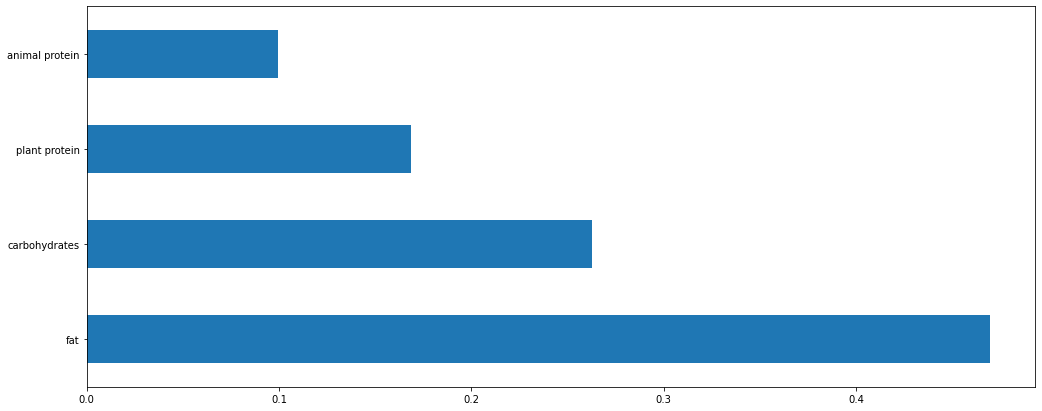

In [34]:
print(r.feature_importances_)
feat_importances = pd.Series(r.feature_importances_, index=testX.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [35]:
diet_comp_cols_with_gdp = ['cereals and grains', 'pulses', 'starchy roots', 'sugar', 'oils and fats', 'meat', 'dairy and eggs', 'fruits and vegetables', 'alcoholic beverages']
diet_comp_cols = ['cereals and grains', 'pulses', 'starchy roots', 'sugar', 'oils and fats', 'meat', 'dairy and eggs', 'fruits and vegetables', 'alcoholic beverages']
diet_comp_gdp = clean50[diet_comp_cols_with_gdp]
diet_comp = clean50[diet_comp_cols]

In [36]:
dietX = diet_comp
dietY = clean50['mortality']

X_train, X_test, y_train, y_test = train_test_split(dietX, dietY, test_size=0.2, random_state=1)
rDiet = DecisionTreeRegressor()
rDiet.fit(X_train, y_train)
y_pred = rDiet.predict(X_test)


df = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
df


,Actual,Predicted
Country,,
Dominican Republic,20.633333,13.233333
Russia,34.833333,19.100000
Bulgaria,27.033333,19.266667
United Kingdom,14.266667,14.200000
Romania,25.066667,20.800000
Greece,13.800000,13.833333
Luxembourg,13.200000,13.100000
Japan,10.433333,17.566667
Jordan,22.166667,17.566667


[0.0715499  0.22635275 0.15506172 0.04148665 0.30585408 0.07417654
 0.02238091 0.10238818 0.00074926]


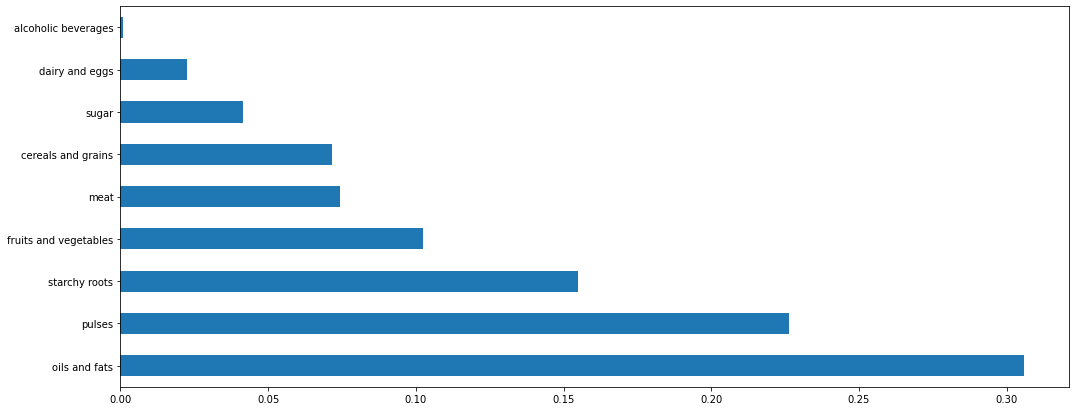

In [37]:
print(rDiet.feature_importances_)
feat_importances = pd.Series(rDiet.feature_importances_, index=dietX.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [38]:
print("HIGHEST 25% QUARTILE GDP")
clean25 = top_25_GDP.dropna()
macro_cols = ['animal protein', 'fat', 'carbohydrates', 'plant protein']
macronutrient = clean25[macro_cols]
macronutrient
testX = macronutrient
testY = clean25['mortality']
mean = testY.mean()
mean
X_train, X_test, y_train, y_test = train_test_split(testX, testY, test_size=0.2, random_state=1)
r = DecisionTreeRegressor()
r.fit(X_train, y_train)
y_pred = r.predict(X_test)
df = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
df

HIGHEST 25% QUARTILE GDP


,Actual,Predicted
Country,,
Spain,12.133333,11.800000
United Kingdom,14.266667,15.600000
Slovenia,16.033333,13.100000
Canada,12.700000,15.600000
Kuwait,20.500000,23.433333
Italy,11.800000,13.800000
Malta,13.233333,20.066667
New Zealand,13.666667,20.066667


In [39]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 3.208333333333333
Mean Squared Error: 14.895277777777778
Root Mean Squared Error: 3.8594400860458733


[0.462102   0.08648616 0.38595417 0.06545767]


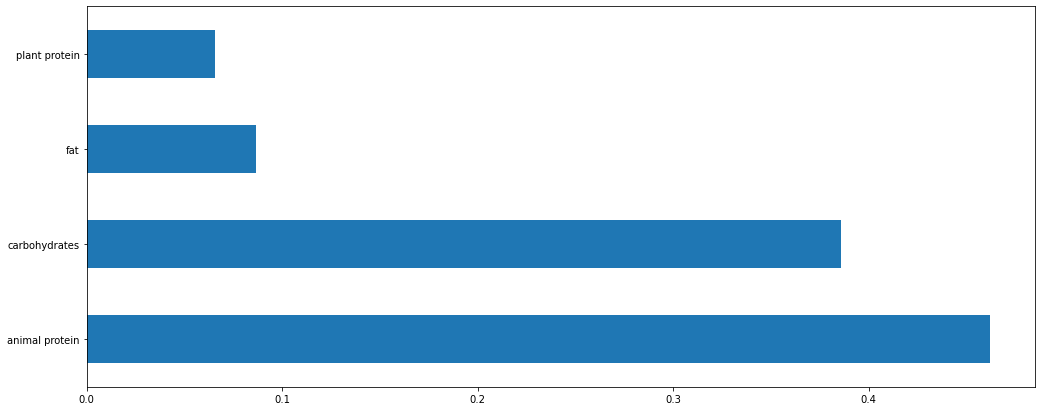

In [40]:
print(r.feature_importances_)
feat_importances = pd.Series(r.feature_importances_, index=testX.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [41]:
diet_comp_cols_with_gdp = ['cereals and grains', 'pulses', 'starchy roots', 'sugar', 'oils and fats', 'meat', 'dairy and eggs', 'fruits and vegetables', 'alcoholic beverages']
diet_comp_cols = ['cereals and grains', 'pulses', 'starchy roots', 'sugar', 'oils and fats', 'meat', 'dairy and eggs', 'fruits and vegetables', 'alcoholic beverages']
diet_comp_gdp = clean25[diet_comp_cols_with_gdp]
diet_comp = clean25[diet_comp_cols]

In [42]:
dietX = diet_comp
dietY = clean25['mortality']

X_train, X_test, y_train, y_test = train_test_split(dietX, dietY, test_size=0.2, random_state=1)
rDiet = DecisionTreeRegressor()
rDiet.fit(X_train, y_train)
y_pred = rDiet.predict(X_test)


df = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
df

,Actual,Predicted
Country,,
Spain,12.133333,13.833333
United Kingdom,14.266667,12.733333
Slovenia,16.033333,14.200000
Canada,12.700000,12.433333
Kuwait,20.500000,12.433333
Italy,11.800000,13.233333
Malta,13.233333,14.200000
New Zealand,13.666667,14.200000


[0.00000000e+00 2.55846305e-03 2.22918509e-02 1.10957520e-02
 1.79076842e-04 7.63473712e-01 4.48876923e-04 3.55872449e-02
 1.64365023e-01]


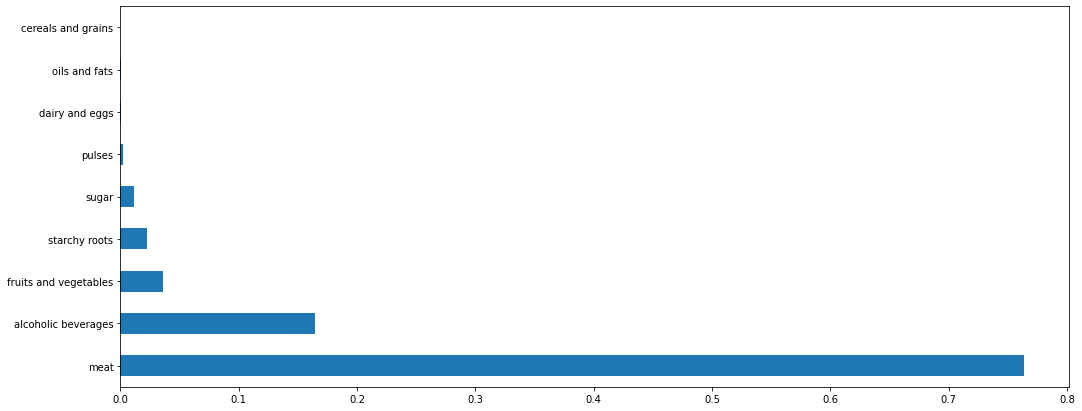

In [43]:
print(rDiet.feature_importances_)
feat_importances = pd.Series(rDiet.feature_importances_, index=dietX.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [44]:
print("LOWEST 25% QUARTILE GDP")
cleanlow25 = last_25_GDP.dropna()
macro_cols = ['animal protein', 'fat', 'carbohydrates', 'plant protein']
macronutrient = cleanlow25[macro_cols]
macronutrient
testX = macronutrient
testY = cleanlow25['mortality']
mean = testY.mean()
mean
X_train, X_test, y_train, y_test = train_test_split(testX, testY, test_size=0.2, random_state=1)
r = DecisionTreeRegressor()
r.fit(X_train, y_train)
y_pred = r.predict(X_test)
df = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
df

LOWEST 25% QUARTILE GDP


,Actual,Predicted
Country,,
Nigeria,24.433333,25.800000
Slovakia,22.866667,17.366667
Guinea-Bissau,22.400000,24.933333
Oman,21.800000,21.400000
Niger,20.633333,26.700000
Lebanon,19.633333,18.400000
Montenegro,22.100000,13.233333
Guinea,22.933333,24.933333
Finland,13.100000,12.566667


[0.59493724 0.09712704 0.18469886 0.12323686]


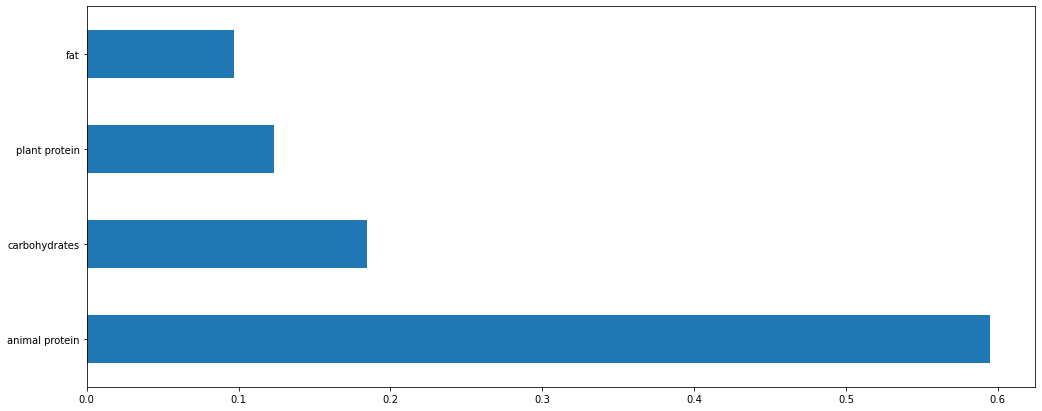

In [45]:
print(r.feature_importances_)
feat_importances = pd.Series(r.feature_importances_, index=testX.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [46]:
diet_comp_cols_with_gdp = ['cereals and grains', 'pulses', 'starchy roots', 'sugar', 'oils and fats', 'meat', 'dairy and eggs', 'fruits and vegetables', 'alcoholic beverages']
diet_comp_cols = ['cereals and grains', 'pulses', 'starchy roots', 'sugar', 'oils and fats', 'meat', 'dairy and eggs', 'fruits and vegetables', 'alcoholic beverages']
diet_comp_gdp = cleanlow25[diet_comp_cols_with_gdp]
diet_comp = cleanlow25[diet_comp_cols]

In [47]:
dietX = diet_comp
dietY = cleanlow25['mortality']

X_train, X_test, y_train, y_test = train_test_split(dietX, dietY, test_size=0.2, random_state=1)
rDiet = DecisionTreeRegressor()
rDiet.fit(X_train, y_train)
y_pred = rDiet.predict(X_test)


df = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
df

,Actual,Predicted
Country,,
Nigeria,24.433333,24.466667
Slovakia,22.866667,31.000000
Guinea-Bissau,22.400000,26.700000
Oman,21.800000,18.400000
Niger,20.633333,25.700000
Lebanon,19.633333,20.233333
Montenegro,22.100000,24.566667
Guinea,22.933333,17.766667
Finland,13.100000,11.800000


[0.02033938 0.1352604  0.20435843 0.01786616 0.04212229 0.32080368
 0.03325646 0.17951424 0.04647898]


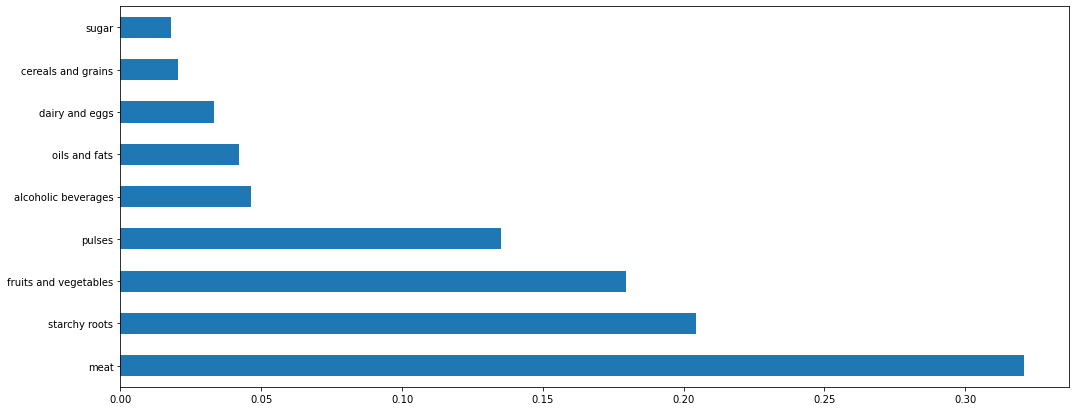

In [48]:
print(rDiet.feature_importances_)
feat_importances = pd.Series(rDiet.feature_importances_, index=dietX.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

## PCA (Principal Component Analysis) + KNN (K-Nearest Neighbors)

We decided to use PCA in order to generate clusters within our data with respect to the GDP quartile they are located in which reduced the features' dimensionality. However, after witnessing the results, we felt it was necessary to combine the results of PCA with KNN in order to optimize accuracy.

In [61]:
#Functions in preparation for PCA

def mortality75(test):
    lst = []
    for a in test:
        if a < 16.5:
            lst.append(0)
        elif a <= 37:
            lst.append(1)
    return lst

def mortality50(test):
    lst = []
    for a in test:
        if a < 18.900000:
            lst.append(0)
        elif a <= 37:
            lst.append(1)
    return lst

def mortality25(test):
    lst = []
    for a in test:
        if a < 13.733333:
            lst.append(0)
        elif a <= 37:
            lst.append(1)
    return lst

def mortalitylow25(test):
    lst = []
    for a in test:
        if a < 20.833333:
            lst.append(0)
        elif a <= 37:
            lst.append(1)
    return lst

In [63]:
pca = PCA(n_components=2)
print("PCA FOR TOP 75% QUARTILE")
clean75 = top_75_GDP.dropna()
macro_cols = ['animal protein', 'fat', 'carbohydrates', 'plant protein']
macronutrient = clean75[macro_cols]
macronutrient
testX = macronutrient
reduced = pca.fit_transform(testX)
testY = mortality75(clean75['mortality'])

X_train, X_test, y_train, y_test = train_test_split(reduced, testY, test_size=0.2, random_state=1)
r = KNeighborsClassifier(n_neighbors=2)
r.fit(X_train, y_train)
y_pred = r.predict(X_test)
df = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
df

PCA FOR TOP 75% QUARTILE


,Actual,Predicted
0,1,1
1,1,0
2,1,0
3,1,0
4,1,1
5,1,1
6,1,1
7,1,0
8,0,1
9,0,0


In [56]:
pca = PCA(n_components=2)
print("PCA FOR TOP 50% QUARTILE")
clean25 = top_50_GDP.dropna()
macro_cols = ['animal protein', 'fat', 'carbohydrates', 'plant protein']
macronutrient =clean50[macro_cols]
macronutrient
testX = macronutrient
reduced = pca.fit_transform(testX)
testY = mortality50(clean50['mortality'])

X_train, X_test, y_train, y_test = train_test_split(reduced, testY, test_size=0.2, random_state=1)
r = KNeighborsClassifier(n_neighbors=2)
r.fit(X_train, y_train)
y_pred = r.predict(X_test)
df = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
df

PCA FOR TOP 50% QUARTILE


,Actual,Predicted
0,1,0
1,1,0
2,1,1
3,0,0
4,1,1
5,0,0
6,0,0
7,0,1
8,1,0
9,0,1


In [55]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
print("PCA FOR TOP 25% QUARTILE")
clean25 = top_25_GDP.dropna()
macro_cols = ['animal protein', 'fat', 'carbohydrates', 'plant protein']
macronutrient = clean25[macro_cols]
macronutrient
testX = macronutrient
reduced = pca.fit_transform(testX)
testY = mortality25(clean25['mortality'])

X_train, X_test, y_train, y_test = train_test_split(reduced, testY, test_size=0.2, random_state=1)
r = KNeighborsClassifier(n_neighbors=2)
r.fit(X_train, y_train)
y_pred = r.predict(X_test)
df = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
df

PCA FOR TOP 25% QUARTILE


,Actual,Predicted
0,0,0
1,1,1
2,1,0
3,0,0
4,1,1
5,0,0
6,0,1
7,0,1


In [62]:
pca = PCA(n_components=2)
print("PCA FOR LOWEST 25% QUARTILE")
cleanlow25 = last_25_GDP.dropna()
macro_cols = ['animal protein', 'fat', 'carbohydrates', 'plant protein']
macronutrient =cleanlow25[macro_cols]
macronutrient
testX = macronutrient
reduced = pca.fit_transform(testX)
testY = mortalitylow25(cleanlow25['mortality'])

X_train, X_test, y_train, y_test = train_test_split(reduced, testY, test_size=0.2, random_state=1)
r = KNeighborsClassifier(n_neighbors=2)
r.fit(X_train, y_train)
y_pred = r.predict(X_test)
df = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
df

PCA FOR LOWEST 25% QUARTILE


,Actual,Predicted
0,1,0
1,1,1
2,1,0
3,1,0
4,0,0
5,0,0
6,1,0
7,1,0
8,0,0
9,1,0


## OLS (Ordinary least Squares)

The reasoning behind calculating the OLS is to determine whether the R^2 coefficient can provide us a strong enough correlation between all the macronutrients and mortality rates of a randomly selected quartile GDP for countries.


In [66]:
import patsy
import statsmodels.api as sm
clean75 = clean75.rename(columns = {"animal protein" : "animal_protein", "plant protein" : "plant_protein"})
outcome_1, predictors_1 = patsy.dmatrices('mortality ~ fat + carbohydrates + animal_protein + plant_protein', data=clean75)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:              mortality   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.226
Method:                 Least Squares   F-statistic:                     9.033
Date:                Wed, 17 Mar 2021   Prob (F-statistic):           2.57e-06
Time:                        23:56:02   Log-Likelihood:                -344.84
No. Observations:                 111   AIC:                             699.7
Df Residuals:                     106   BIC:                             713.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         27.8755      4.950      5.

## Linear Regression

We generated scatterplots in order to determine the relationship between particular macronutrient groups and mortality rate.

HIGHEST 75% QUARTILE GDP


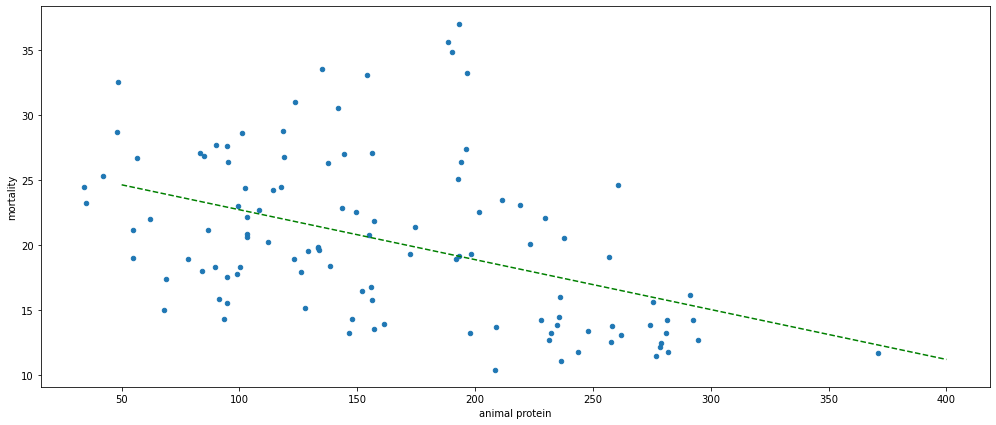

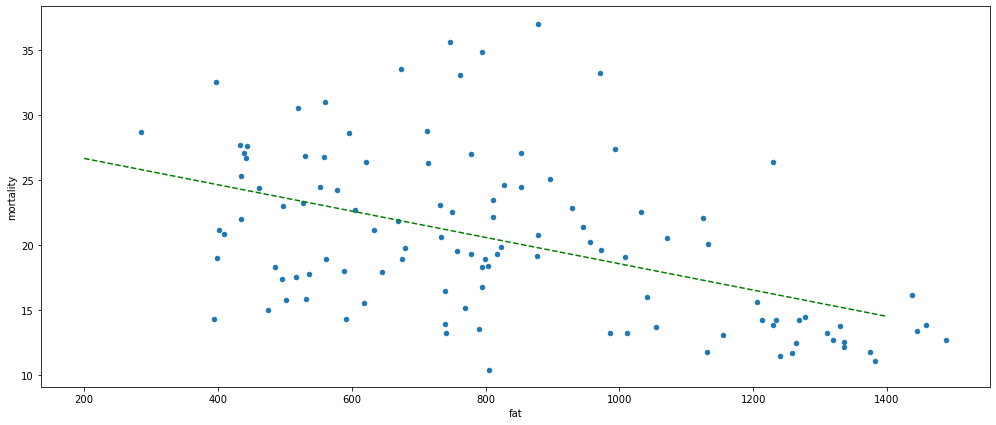

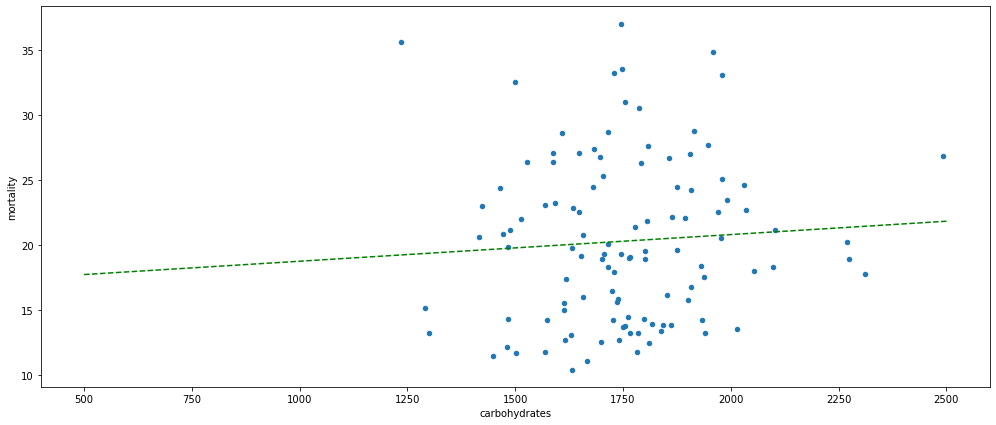

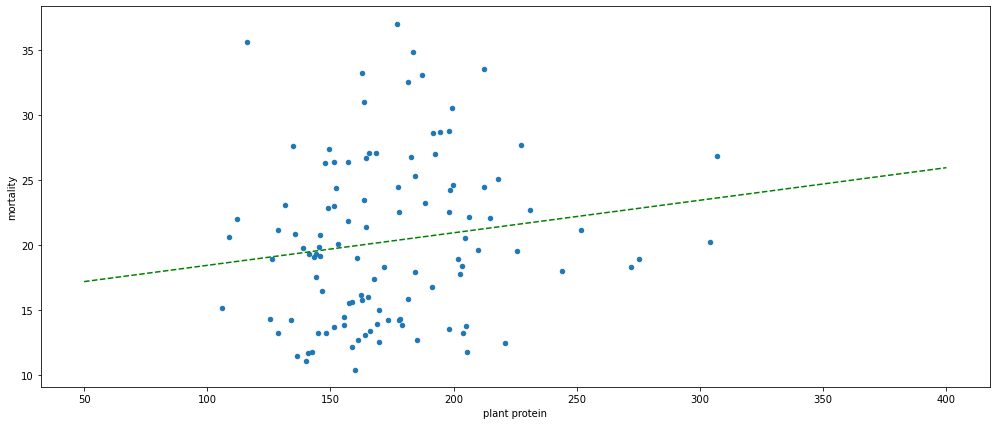

In [49]:
from sklearn.linear_model import LinearRegression

#macro_cols = ['animal protein', 'fat', 'carbohydrates', 'plant protein']
print("HIGHEST 75% QUARTILE GDP")

clean75scatter = clean75.plot.scatter(x = "animal protein", y = "mortality")
x_75 = clean75["animal protein"].values.reshape(-1, 1)
y_75 = clean75["mortality"].values.reshape(-1, 1)
reg75 = LinearRegression().fit(x_75, y_75)
Y, b = reg75.intercept_, reg75.coef_
X = np.array([50, 100, 150, 200, 250, 300, 350, 400])
X = X.reshape(-1, 1)
s = clean75scatter.plot(X, b*X + Y, "--g")

clean75scatter = clean75.plot.scatter(x = "fat", y = "mortality")
x_75 = clean75["fat"].values.reshape(-1, 1)
y_75 = clean75["mortality"].values.reshape(-1, 1)
reg75 = LinearRegression().fit(x_75, y_75)
Y, b = reg75.intercept_, reg75.coef_
X = np.array([200, 400, 600, 800, 1000, 1200, 1400])
X = X.reshape(-1, 1)
s = clean75scatter.plot(X, b*X + Y, "--g")

clean75scatter = clean75.plot.scatter(x = "carbohydrates", y = "mortality")
x_75 = clean75["carbohydrates"].values.reshape(-1, 1)
y_75 = clean75["mortality"].values.reshape(-1, 1)
reg75 = LinearRegression().fit(x_75, y_75)
Y, b = reg75.intercept_, reg75.coef_
X = np.array([500, 1000, 1500, 2000, 2500])
X = X.reshape(-1, 1)
s = clean75scatter.plot(X, b*X + Y, "--g")

clean75scatter = clean75.plot.scatter(x = "plant protein", y = "mortality")
x_75 = clean75["plant protein"].values.reshape(-1, 1)
y_75 = clean75["mortality"].values.reshape(-1, 1)
reg75 = LinearRegression().fit(x_75, y_75)
Y, b = reg75.intercept_, reg75.coef_
X = np.array([50, 100, 150, 200, 250, 300, 350, 400])
X = X.reshape(-1, 1)
s = clean75scatter.plot(X, b*X + Y, "--g")


In the highest 75% quartile:
- Animal protein & mortality rate resulted in a coefficient of -0.0383188
- Fat & mortality rate resulted in a coefficient of -0.01011182
- Carbohydrates & mortality rate resulted in a coefficient of 0.00204769
- Plant protein & morality rate resulted in a coefficient of 0.02500179

HIGHEST 50% QUARTILE GDP


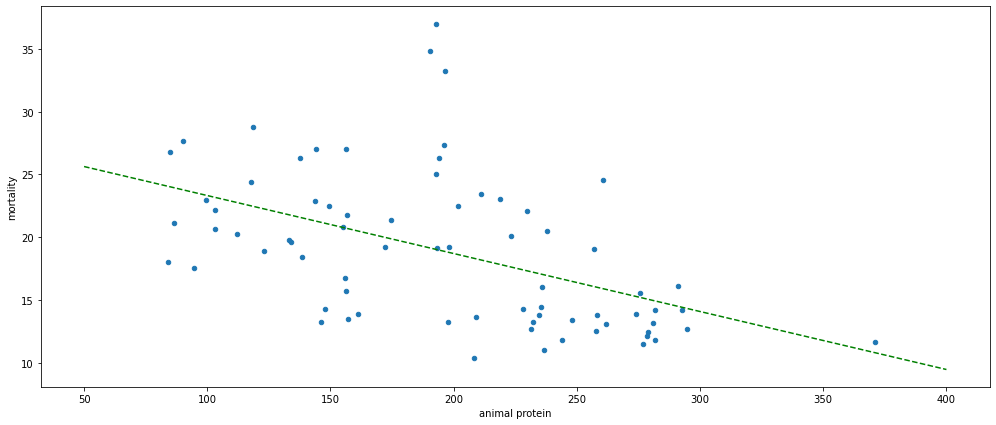

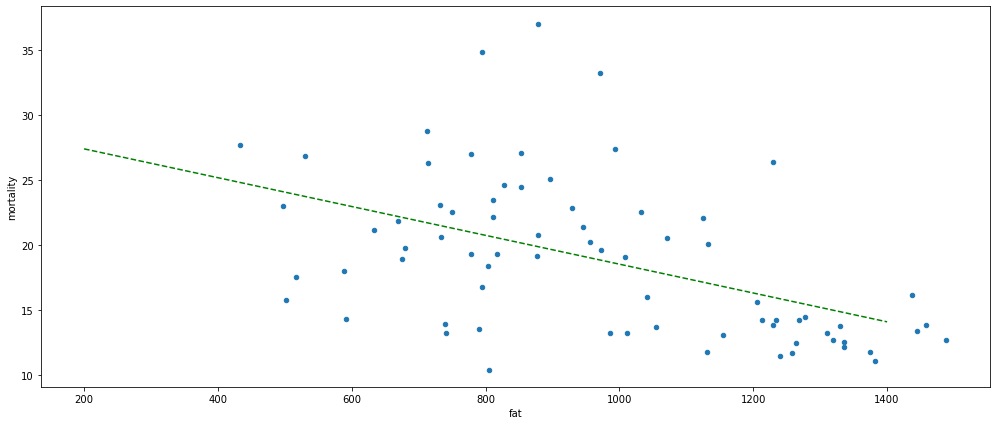

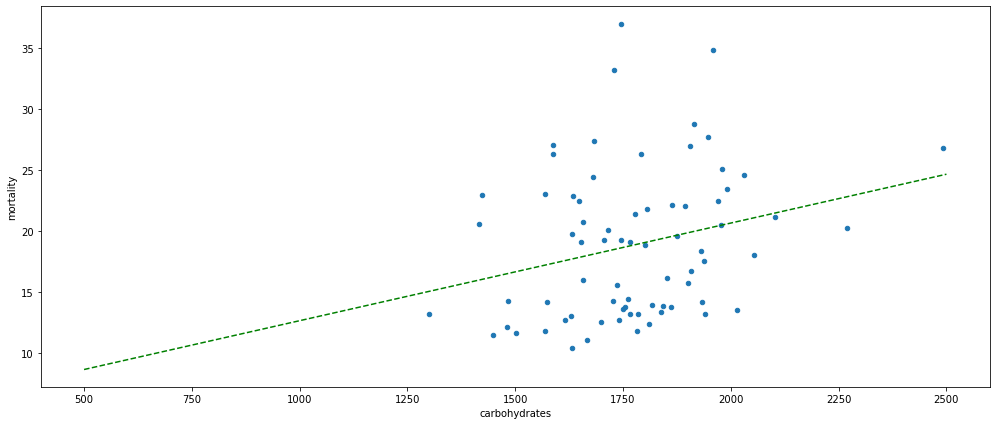

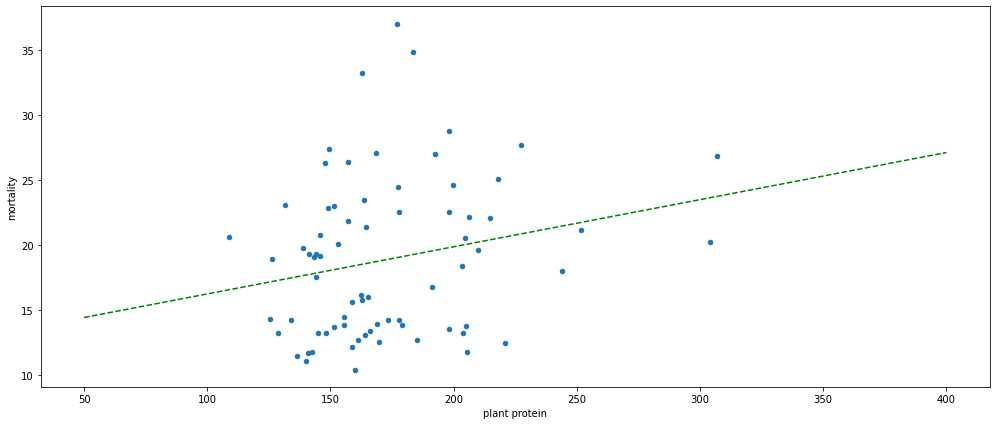

In [50]:
print("HIGHEST 50% QUARTILE GDP")
clean50scatter = clean50.plot.scatter(x = "animal protein", y = "mortality")
x_50 = clean50["animal protein"].values.reshape(-1, 1)
y_50 = clean50["mortality"].values.reshape(-1, 1)
reg50 = LinearRegression().fit(x_50, y_50)
Y, b = reg50.intercept_, reg50.coef_
X = np.array([50, 100, 150, 200, 250, 300, 350, 400])
X = X.reshape(-1, 1)
s = clean50scatter.plot(X, b*X + Y, "--g")

clean50scatter = clean50.plot.scatter(x = "fat", y = "mortality")
x_50 = clean50["fat"].values.reshape(-1, 1)
y_50 = clean50["mortality"].values.reshape(-1, 1)
reg50 = LinearRegression().fit(x_50, y_50)
Y, b = reg50.intercept_, reg50.coef_
X = np.array([200, 400, 600, 800, 1000, 1200, 1400])
X = X.reshape(-1, 1)
s = clean50scatter.plot(X, b*X + Y, "--g")

clean50scatter = clean50.plot.scatter(x = "carbohydrates", y = "mortality")
x_50 = clean50["carbohydrates"].values.reshape(-1, 1)
y_50 = clean50["mortality"].values.reshape(-1, 1)
reg50 = LinearRegression().fit(x_50, y_50)
Y, b = reg50.intercept_, reg50.coef_
X = np.array([500, 1000, 1500, 2000, 2500])
X = X.reshape(-1, 1)
s = clean50scatter.plot(X, b*X + Y, "--g")

clean50scatter = clean50.plot.scatter(x = "plant protein", y = "mortality")
x_50 = clean50["plant protein"].values.reshape(-1, 1)
y_50 = clean50["mortality"].values.reshape(-1, 1)
reg50 = LinearRegression().fit(x_50, y_50)
Y, b = reg50.intercept_, reg50.coef_
X = np.array([50, 100, 150, 200, 250, 300, 350, 400])
X = X.reshape(-1, 1)
s = clean50scatter.plot(X, b*X + Y, "--g")

In the highest 50% quartile:
- Animal protein & mortality rate resulted in a coefficient of -0.04612311
- Fat & mortality rate resulted in a coefficient of -0.01106993
- Carbohydrates & mortality rate resulted in a coefficient of 0.00799131
- Plant protein & morality rate resulted in a coefficient of 0.03620258

HIGHEST 25% QUARTILE GDP


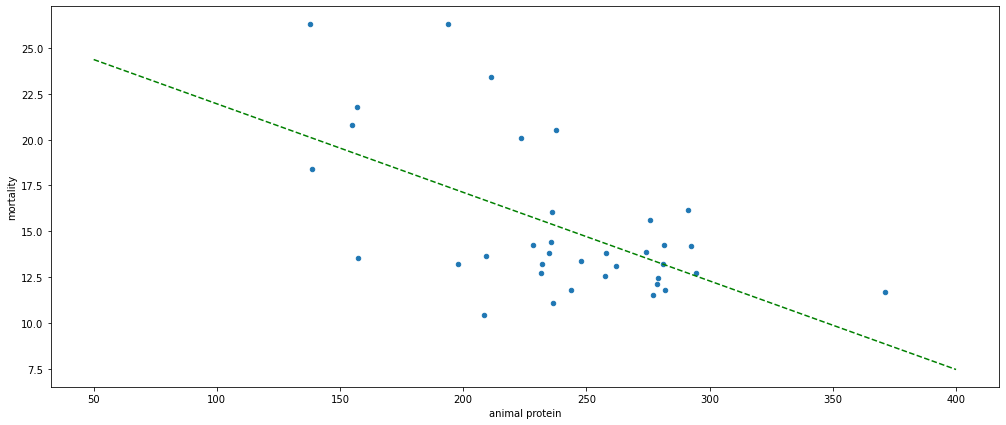

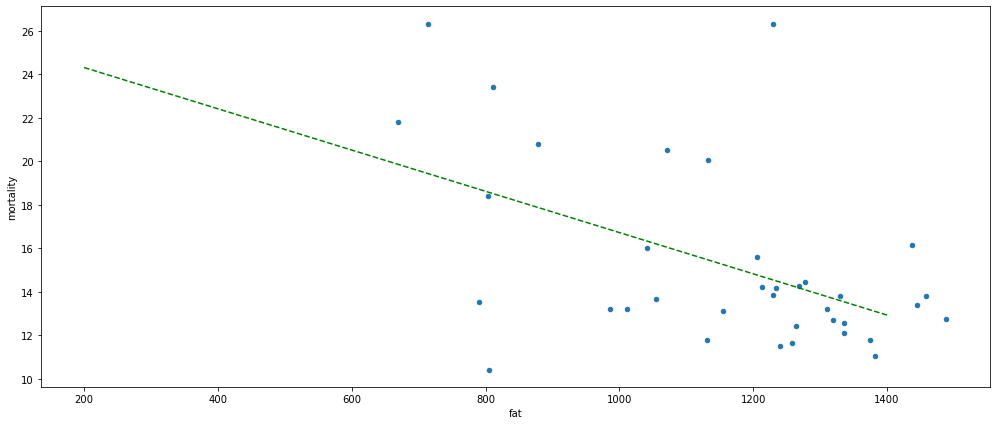

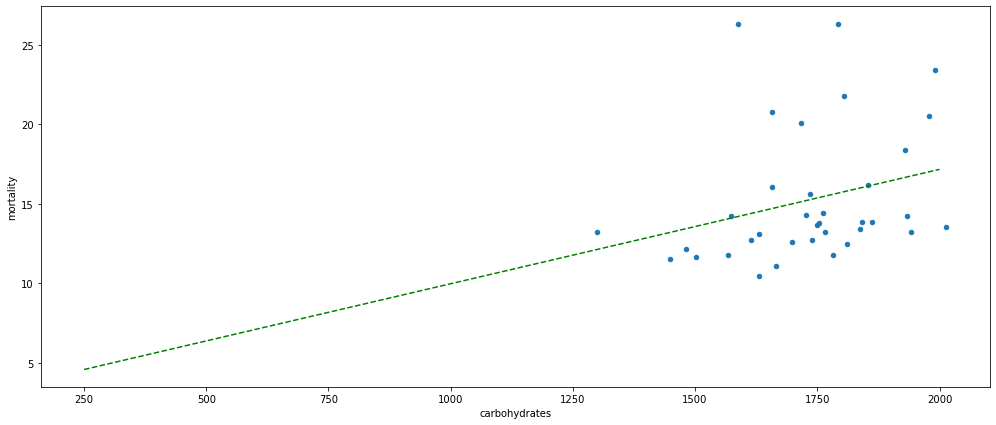

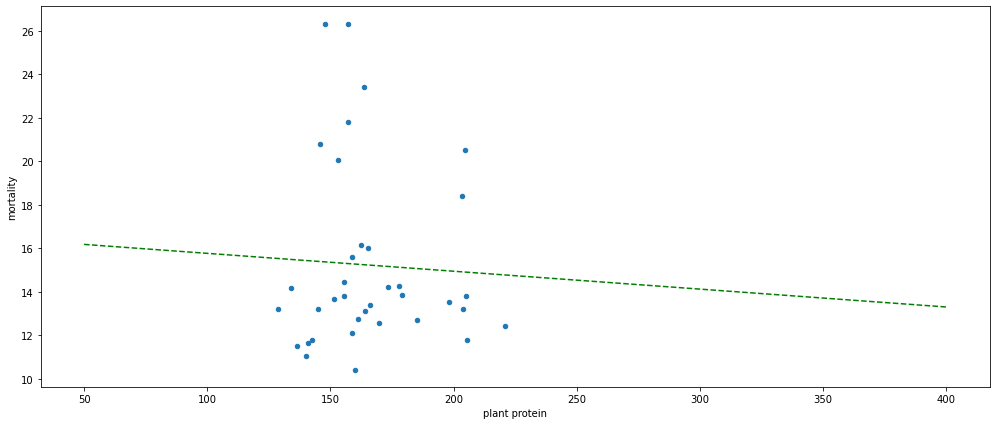

In [51]:
print("HIGHEST 25% QUARTILE GDP")

clean25scatter = clean25.plot.scatter(x = "animal protein", y = "mortality")
x_25 = clean25["animal protein"].values.reshape(-1, 1)
y_25 = clean25["mortality"].values.reshape(-1, 1)
reg25 = LinearRegression().fit(x_25, y_25)
Y, b = reg25.intercept_, reg25.coef_
X = np.array([50, 100, 150, 200, 250, 300, 350, 400])
X = X.reshape(-1, 1)
s = clean25scatter.plot(X, b*X + Y, "--g")

clean25scatter = clean25.plot.scatter(x = "fat", y = "mortality")
x_25 = clean25["fat"].values.reshape(-1, 1)
y_25 = clean25["mortality"].values.reshape(-1, 1)
reg25 = LinearRegression().fit(x_25, y_25)
Y, b = reg25.intercept_, reg25.coef_
X = np.array([200, 400, 600, 800, 1000, 1200, 1400])
X = X.reshape(-1, 1)
s = clean25scatter.plot(X, b*X + Y, "--g")

clean25scatter = clean25.plot.scatter(x = "carbohydrates", y = "mortality")
x_25 = clean25["carbohydrates"].values.reshape(-1, 1)
y_25 = clean25["mortality"].values.reshape(-1, 1)
reg25 = LinearRegression().fit(x_25, y_25)
Y, b = reg25.intercept_, reg25.coef_
X = np.array([250, 500, 720, 1000, 1250, 1500, 1750, 2000])
X = X.reshape(-1, 1)
s = clean25scatter.plot(X, b*X + Y, "--g")

clean25scatter = clean25.plot.scatter(x = "plant protein", y = "mortality")
x_25 = clean25["plant protein"].values.reshape(-1, 1)
y_25 = clean25["mortality"].values.reshape(-1, 1)
reg25 = LinearRegression().fit(x_25, y_25)
Y, b = reg25.intercept_, reg25.coef_
X = np.array([50, 100, 150, 200, 250, 300, 350, 400])
X = X.reshape(-1, 1)
s = clean25scatter.plot(X, b*X + Y, "--g")

In the highest 25% quartile:
- Animal protein & mortality rate resulted in a coefficient of -0.04833149
- Fat & mortality rate resulted in a coefficient of -0.00948304
- Carbohydrates & mortality rate resulted in a coefficient of 0.00719608
- Plant protein & morality rate resulted in a coefficient of -0.00822191

LOWEST 25% QUARTILE GDP


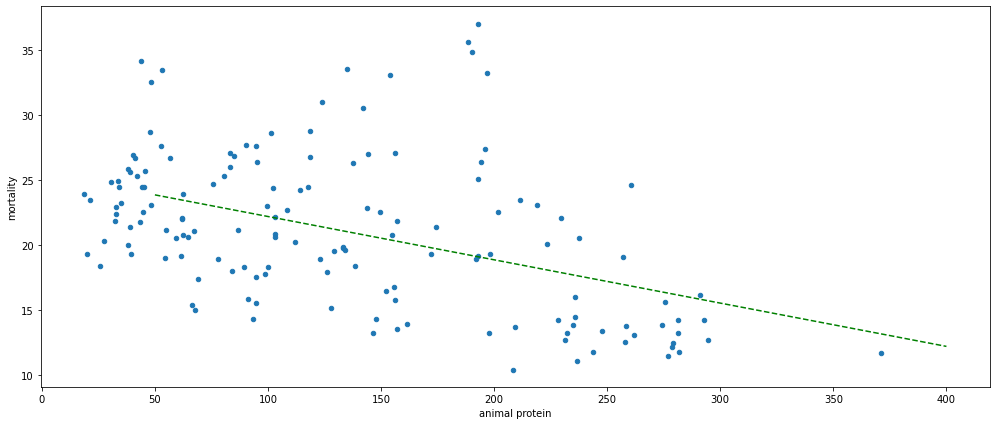

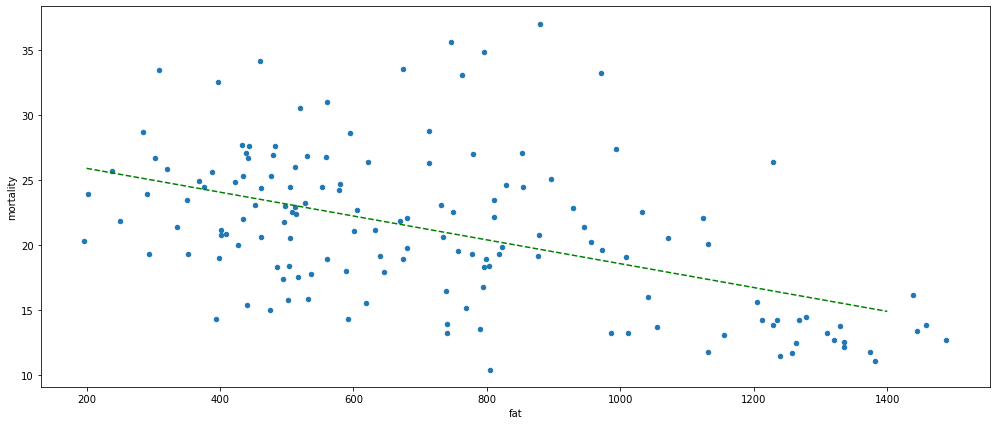

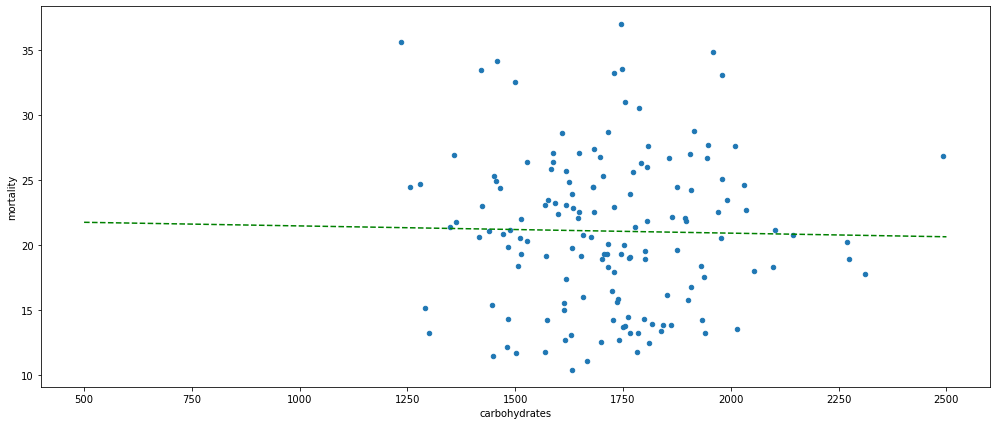

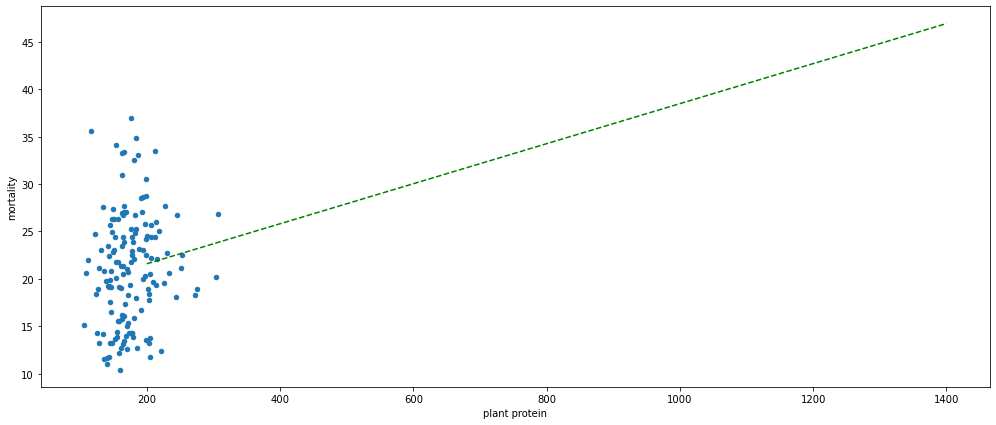

In [52]:
print("LOWEST 25% QUARTILE GDP")

cleanlow25scatter = cleanlow25.plot.scatter(x = "animal protein", y = "mortality")
x_low25 = cleanlow25["animal protein"].values.reshape(-1, 1)
y_low25 = cleanlow25["mortality"].values.reshape(-1, 1)
reglow25 = LinearRegression().fit(x_low25, y_low25)
Y, b = reglow25.intercept_, reglow25.coef_
X = np.array([50, 100, 150, 200, 250, 300, 350, 400])
X = X.reshape(-1, 1)
s = cleanlow25scatter.plot(X, b*X + Y, "--g")

cleanlow25scatter = cleanlow25.plot.scatter(x = "fat", y = "mortality")
x_low25 = cleanlow25["fat"].values.reshape(-1, 1)
y_low25 = cleanlow25["mortality"].values.reshape(-1, 1)
reglow25 = LinearRegression().fit(x_low25, y_low25)
Y, b = reglow25.intercept_, reglow25.coef_
X = np.array([200, 400, 600, 800, 1000, 1200, 1400])
X = X.reshape(-1, 1)
s = cleanlow25scatter.plot(X, b*X + Y, "--g")

cleanlow25scatter = cleanlow25.plot.scatter(x = "carbohydrates", y = "mortality")
x_low25 = cleanlow25["carbohydrates"].values.reshape(-1, 1)
y_low25 = cleanlow25["mortality"].values.reshape(-1, 1)
reglow25 = LinearRegression().fit(x_low25, y_low25)
Y, b = reglow25.intercept_, reglow25.coef_
X = np.array([500, 1000, 1500, 2000, 2500])
X = X.reshape(-1, 1)
s = cleanlow25scatter.plot(X, b*X + Y, "--g")

cleanlow25scatter = cleanlow25.plot.scatter(x = "plant protein", y = "mortality")
x_low25 = cleanlow25["plant protein"].values.reshape(-1, 1)
y_low25 = cleanlow25["mortality"].values.reshape(-1, 1)
reglow25 = LinearRegression().fit(x_low25, y_low25)
Y, b = reglow25.intercept_, reglow25.coef_
X = np.array([200, 400, 600, 800, 1000, 1200, 1400])
X = X.reshape(-1, 1)
s = cleanlow25scatter.plot(X, b*X + Y, "--g")

In the lowest 25% quartile:
- Animal protein & mortality rate resulted in a coefficient of -0.03324871
- Fat & mortality rate resulted in a coefficient of -0.00915552
- Carbohydrates & mortality rate resulted in a coefficient of -0.00055594
- Plant protein & morality rate resulted in a coefficient of 0.02112196

## Ethics & Privacy

All of the data used for our project is available in the public domain, so there are not major concerns in the privacy of certain individuals or users by our project and research. The information is provided by “Our World in Data,” which is free and accessible information on the internet. 

However, when considering the results and analysis of our results, despite our efforts, there are plenty of confounding variables that may be affecting the rates of non-communicable diseases outside of diet. These variables include different countries' GDPs, healthcare expenditures, and other cultural differences that may affect mortality rates. Cultural differences like the normalization of smoking in certain countries may also affect these results outside of diet. Our project has made efforts to combat and narrow out these confounding variables, but due to the complexity of human life we must acknowledge that they still have a confounding effect on our results.

Our findings also have the possibility of affecting the well-being of certain populations. If research like this were to be further investigated and maybe even used to perpetuate change in diet across different countries, it must also be acknowledged diets hold cultural value and cannot be dictated strictly for health reasons without first acknowledging the cultural importance of certain foods and diets.

## Conclusion & Discussion

We initially hypothesized that poor diet is one of the main risk factors in contracting noncommunicable disease, as well as media and dieticians reminding all demographics how maintaining a healthy dietary composition is necessary in a high life expectancy. Drawing our inspiration from the database in Our World in Data, dating from 2000 to 2010, we imagined that specific macronutrients and general food groups (i.e. sugar) could have different weights in evaluating a country’s life expectancy. However, as we cleaned our data and brainstormed the possible multivariate features that may otherwise affect the mortality rates of these countries, especially GDP, which presented a weight larger than 0.3 in the initial decision tree we ran with the various food groups. Thus, we resorted to sectoring the countries into their own socioeconomic categories via four quartiles presented in the summary statistics of our database’s GDP annual values averaged per country. Indeed, after running an OLS scan through one of the GDP sectors we realized that a positive R^2 coefficient signified the presence of a correlation between macronutrient food groups and mortality rates.

Additionally, we ran three different approaches to specifically classify the prediction of mortality rates through these food groups: 1) a Decision Tree per GDP quartile to represent which food groups affect each GDP the most, 2) a Linear Discriminatory Analysis that shaped our training data through a base rule of 0 and 1 (0 representing low mortality, 1 being high) so we would have concrete results as to testing our database, and 3) a KNN and PCA merged classifier that optimized accuracy and increased the precision of the test data run through, via characterizing the clusters of diets together within the database. We cleaned the data through averaging the total food group caloric intake and GDP per country and redacting any countries missing any data. We also provided various visualizations as to how the distributions of particular food groups lie within the entire span of the database.

Throughout the data cleaning and analysis, we realize that the fact that we even had to sector each GDP quartile away and found that distinct food groups affected the GDP quartiles differently, we realize that our hypothesis has only been partially answered. Yes, the necessity of a proper diet is clear, but the confounding variable of standard of living and the ability to purchase the food and to gain awareness of a healthy diet usually leaned more towards higher GDP or wealthier countries, which is unfair yet true. Further studies may be recommended simply to analyze the data even further to take into consideration other confounding variables and isolate dietary composition entirely, but simply due to socioeconomic and cultural constructs, we found that we can only qualifiedly affirm our hypothesis with the data analysis corroborating it.


## Team Contributions

#### Brandon:
- Made final project video
- Wrote Ethics & Privacy section
- Wrote EDA descriptions

#### Eva:
- Hosted and scheduled Zoom meetings
- Wrote Background section
- Wrote EDA descriptions
- Conducted analysis (linear regression)

#### Justin:
- Data cleaning
- EDA
- Conducted analysis (decision tree, LDA)

#### Rhee:
- Data cleaning
- EDA
- Conducted analysis (decision tree, LDA, KNN, OLS)
